In [1]:
"""
R001_Fall_2023_AI_Reproducibility__
|
R001_ii_Extend_CC25k_Dataset.ipynb
Created on Mon May 26 08:30:48 2025
@author: Rochana Obadage
"""

# Get contexts from Semantic Scholar Graph API

## ``Collecting Paper IDs from R_004 S2ORC`` 

In [1]:
import json
import os
import glob

paper_details_foders = glob.glob(r'../R_004/s2orc_paper_details/*')
paper_details_foders

['../R_004/s2orc_paper_details/s2orc_1',
 '../R_004/s2orc_paper_details/s2orc_179',
 '../R_004/s2orc_paper_details/s2orc_235',
 '../R_004/s2orc_paper_details/s2orc_64',
 '../R_004/s2orc_paper_details/s2orc_128',
 '../R_004/s2orc_paper_details/s2orc_16',
 '../R_004/s2orc_paper_details/s2orc_99',
 '../R_004/s2orc_paper_details/s2orc_268',
 '../R_004/s2orc_paper_details/s2orc_256',
 '../R_004/s2orc_paper_details/s2orc_78',
 '../R_004/s2orc_paper_details/s2orc_2',
 '../R_004/s2orc_paper_details/s2orc_182',
 '../R_004/s2orc_paper_details/s2orc_90',
 '../R_004/s2orc_paper_details/s2orc_245',
 '../R_004/s2orc_paper_details/s2orc_211',
 '../R_004/s2orc_paper_details/s2orc_145',
 '../R_004/s2orc_paper_details/s2orc_88',
 '../R_004/s2orc_paper_details/s2orc_92',
 '../R_004/s2orc_paper_details/s2orc_20',
 '../R_004/s2orc_paper_details/s2orc_62',
 '../R_004/s2orc_paper_details/s2orc_42',
 '../R_004/s2orc_paper_details/s2orc_269',
 '../R_004/s2orc_paper_details/s2orc_232',
 '../R_004/s2orc_paper_de

In [34]:
cs_paper_details = []

for idx,folder in enumerate(paper_details_foders):
    print(f'Folder {idx+1}: {folder}')
    papers_in_folder = glob.glob(f'{folder}/*.json')

    # for paper in papers_in_folder[:50]:
    for paper in papers_in_folder:
        with open(paper, 'r',encoding = 'utf-8') as f:
            paper_details_dict = json.loads(f.read())

            # year threshold
            if (paper_details_dict.get('year') or 0) >= 2010:

                # field of study - only CS
                if paper_details_dict['s2FieldsOfStudy'] !=[]:
                    paper_s2FieldsOfStudy_list = [item['category'] for item in paper_details_dict['s2FieldsOfStudy'] if item['source'] == 's2-fos-model']
                    # print(paper_s2FieldsOfStudy_list)
                    
                    if 'Computer Science' in paper_s2FieldsOfStudy_list:
                        cs_paper_details.append(paper_details_dict)
                                                                                            

    with open(r'cc25k/extend_cc25k/cs_paper_details.json', 'w', encoding = 'utf-8') as json_file_1:
        json.dump(cs_paper_details, json_file_1, indent=4)

    if idx == 2:
        break
        
cs_paper_details

In [5]:
with open(r'../R_004/s2orc_paper_details/s2orc_235/246057369.json', 'r',encoding = 'utf-8') as f:
        paper_details_dict = json.loads(f.read())
paper_details_dict

{'paperId': '04282e27c564e76bebad71152140a62872a7f8dd',
 'externalIds': {'PubMedCentral': '8979014',
  'DOI': '10.1039/d1ra08742h',
  'CorpusId': 246057369,
  'PubMed': '35425229'},
 'corpusId': 246057369,
 'title': 'Size and surface-energy dependence of the adsorption/desorption equilibrium in ethanol electro-oxidation by Pd-nanoparticles. Theory and experiment',
 'year': 2022,
 'referenceCount': 23,
 'citationCount': 1,
 'openAccessPdf': {'url': 'https://pubs.rsc.org/en/content/articlepdf/2022/ra/d1ra08742h',
  'status': 'GOLD'},
 'fieldsOfStudy': ['Medicine'],
 's2FieldsOfStudy': [{'category': 'Medicine', 'source': 'external'},
  {'category': 'Chemistry', 'source': 's2-fos-model'},
  {'category': 'Materials Science', 'source': 's2-fos-model'}]}

In [3]:
with open(r'cc25k/extend_cc25k/cs_paper_details.json', 'r',encoding = 'utf-8') as f:
        cs_paper_all_dict = json.loads(f.read())

cs_paper_all_dict

paper_ids = [item['paperId'] for item in cs_paper_all_dict if item['year']>2016]
len(paper_ids)

962295

## `get citation contexts for a given s2orc paper id`

In [30]:
import requests
import time

paper_id = "a095dd703670062068b8c2059d30adcef2032c0b"
FIELDS = "contexts,intents,contextsWithIntent,isInfluential,abstract,title,year,publicationVenue,corpusId,externalIds,url,authors,s2FieldsOfStudy,journal"

def fetch_all_citations(paper_id, fields, limit=1000):
    base_url = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}/citations"
    offset = 0
    all_citations_with_contexts = []

    while True:
        params = {
            "fields": fields,
            "offset": offset,
            "limit": limit
        }

        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            print(f"Request failed at offset {offset}: {response.status_code}")
            break

        data = response.json()
        citations = data.get("data", [])

        # Keep only citations where 'contexts' is not empty
        filtered = [c for c in citations if c.get("contexts")]

        all_citations_with_contexts.extend(filtered)
        
        # Check if there are more results
        if "next" in data and data["next"] is not None:
            offset = data["next"]
            time.sleep(2)  # To respect API rate limits
        else:
            break

    return all_citations_with_contexts

all_citations = fetch_all_citations(paper_id, FIELDS)

with open(rf'cc25k/extend_cc25k/all_citation_contexts/{paper_id}.json', 'w', encoding = 'utf-8') as json_file:
    json.dump(all_citations, json_file, indent=4)


In [31]:
for index, paper_id in enumerate(paper_ids):
    
    # url = "https://api.semanticscholar.org/graph/v1/paper/{s2ga_key}?fields=title,authors,citationCount,citations.title,citations.authors,citations.year,citations.publicationVenue,citations.corpusId,citations.url,citations.externalIds".format(s2ga_key=row['s2ga_key'])
    all_citations = fetch_all_citations(paper_id, FIELDS)
   
    with open(rf'cc25k/extend_cc25k/all_citation_contexts/{paper_id}.json', 'w', encoding = 'utf-8') as json_file:
        json.dump(all_citations, json_file, indent=4)
          
    time.sleep(3)
    
    print(f'{index}\n')
    if index == 5:
        time.sleep(10)
        break

0

1

2

3

4

5



In [ ]:
import os
import glob

import ijson
import requests
import json
import time
import random
from pathlib import Path


def fetch_all_citations_with_contexts(paper_id, fields, limit=1000):
    base_url = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}/citations"
    offset = 0
    all_citations_with_contexts = []

    while True:
        params = {"fields": fields, "offset": offset, "limit": limit}
        try:
            response = requests.get(base_url, params=params, timeout=30)
        except requests.exceptions.RequestException as e:
            print(f"Network error at offset {offset}: {e}")
            time.sleep(60)  # wait a full minute before retry
            continue

        if response.status_code == 429:
            print("Rate limited. Sleeping for 2 minutes.")
            time.sleep(120)
            continue
        elif response.status_code != 200:
            print(f"Request failed at offset {offset}: {response.status_code}")
            break

        data = response.json()
        citations = data.get("data", [])
        filtered = [c for c in citations if c.get("contexts")]
        all_citations_with_contexts.extend(filtered)

        if data.get("next") is not None:
            offset = data["next"]
            time.sleep(random.uniform(1.5, 3.5))  # varied delay between paginated requests
        else:
            break

    return all_citations_with_contexts


FIELDS = "contexts,intents,contextsWithIntent,isInfluential,abstract,title,year,publicationVenue,corpusId,externalIds,url,authors,s2FieldsOfStudy,journal"
output_dir = Path("cc25k/extend_cc25k/all_citation_contexts")
output_dir.mkdir(parents=True, exist_ok=True)


def main():

    # Stream one paper at a time from the large JSON file
    with open('cc25k/extend_cc25k/cs_paper_details.json', 'r', encoding='utf-8') as f:
        paper_objects = ijson.items(f, 'item')
    
        for index, paper in enumerate(paper_objects):
            paper_id = paper.get('paperId')

            year = paper.get('year') or 0  # Default to 0 if year is None
    
            if not paper_id or year <= 2016:
                continue
    
            try:
                output_file = output_dir / f"{paper_id}.json"
                if output_file.exists():
                    print(f"Skipping existing: {paper_id}")
                    continue
    
                citations = fetch_all_citations_with_contexts(paper_id, FIELDS)
    
                if citations:  # Only save if we have at least one citation with context
                    with output_file.open('w', encoding='utf-8') as out_f:
                        json.dump(citations, out_f, indent=4)
                    print(f"[{index}] Saved: {paper_id} ({len(citations)} citations)")
                else:
                    print(f"[{index}] Skipped (no citations with context): {paper_id}")
    
                # print(f"[{index}] Done: {paper_id}")
    
                # Short randomized sleep between requests
                time.sleep(random.uniform(2.0, 5.0))
    
                # Medium pause every 50
                if index > 0 and index % 50 == 0:
                    print("Medium pause after 50 papers...")
                    time.sleep(random.uniform(60, 120))
    
                # Longer pause every 1000
                if index > 0 and index % 1000 == 0:
                    print("Longer pause after 1000 papers...")
                    time.sleep(random.uniform(180, 300))
    
            except Exception as e:
                print(f"Error with {paper_id}: {e}")
                time.sleep(30)  # pause briefly on error before continuing


if __name__ == "__main__":
    main()

## `read json files and store contexts in a csv`

In [7]:
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Directory containing your JSON files
input_dir = Path("cc25k/extend_cc25k/all_citation_contexts")
output_csv = Path("cc25k/extend_cc25k/all_in_one_citation_contexts.csv")

rows = []

# Iterate over all JSON files
for json_file in tqdm(input_dir.glob("*.json")):
    try:
        cited_paper_id = json_file.stem  # Filename without .json
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)

        for citation in data:
            contexts = citation.get("contexts", [])
            if not contexts:
                continue  # Skip if no context

            is_influential = citation.get("isInfluential")
            citing_paper = citation.get("citingPaper", {})
            paper_id = citing_paper.get("paperId")
            title = citing_paper.get("title")
            year = citing_paper.get("year")
            publication_venue = citing_paper.get("publicationVenue", {}).get("name") if citing_paper.get("publicationVenue") else None
            authors = citing_paper.get("authors", [])
            author_names = ", ".join(author.get("name") for author in authors)

            for context in contexts:
                rows.append({
                    "cited_paper_id": cited_paper_id,
                    "context": context,
                    "isInfluential": is_influential,
                    "citing_paperId": paper_id,
                    "citing_paper_title": title,
                    "citing_paper_year": year,
                    "citing_paper_publicationVenue": publication_venue,
                    "citing_paper_author_names": author_names
                })

    except Exception as e:
        print(f"Failed to process {json_file.name}: {e}")

# Convert to DataFrame and write to CSV
df = pd.DataFrame(rows)
df.to_csv(output_csv, index=False)
print(f"Saved CSV with {len(df)} rows to {output_csv}")


21757it [00:42, 517.48it/s]


Saved CSV with 692604 rows to cc25k/extend_cc25k/all_in_one_citation_contexts.csv


# 3-class Classifier for Citation Context Reproducibility Oriented Sentiment Classification 

## `preparing the dataset`
Fine-tune a Hugging Face transformer model to classify citation contexts as Positive, Neutral, or Negative for reproducibility sentiment.

In [ ]:
# !pip install transformers datasets scikit-learn pytz

## `prepare the initial dataset`

In [9]:
import pandas as pd
df_ = pd.read_csv(r'cc25k/CC25k_with_metadata.csv')

In [5]:
df_.columns

Index(['input_index', 'input_context', 'input_file_key', 'input_first_author',
       'worker_id_w1', 'work_time_in_seconds_w1', 'label_w1', 'worker_id_w2',
       'work_time_in_seconds_w2', 'label_w2', 'worker_id_w3',
       'work_time_in_seconds_w3', 'label_w3', 'batch', 'majority_vote',
       'majority_agreement', 'rs_doi', 'rs_title', 'rs_authors', 'rs_year',
       'rs_venue', 'rs_selected_claims', 'rs_reproduced_claims', 'rs_score',
       's2ga_key', 'reproducibility', 'rs_key', 'org_doi', 'org_title',
       'org_authors', 'org_year', 'org_venue', 'org_paper_url',
       'org_citations'],
      dtype='object')

In [15]:
df_contexts = df_[['input_context','majority_vote']]

df_negative_sampled = df_contexts[df_contexts['majority_vote']=="Negative"]
df_positive_sampled = df_contexts[df_contexts['majority_vote']=="Positive"].sample(n=279, random_state=42)
df_neutral_sampled = df_contexts[df_contexts['majority_vote']=="Neutral"].sample(n=279, random_state=42)

df_neutral_sampled

,input_context,majority_vote
3356,", in MAE [19]), and is used to generate latent...",Neutral
22409,We fix k2 to be the same as Janner et al. (201...,Neutral
5889,The only method with perfect scores on all SCA...,Neutral
17374,"In this section, we first discuss the differen...",Neutral
18308,"Instead, Sohl-Dickstein et al. (2015) and Song...",Neutral
...,...,...
13165,MAE [27] proposes an asymmetric encoder-decode...,Neutral
1464,The underlying assumption is that a masked aut...,Neutral
14593,These pre-trained masked modeling has been pro...,Neutral
19869,Although the transformer is good at learning s...,Neutral


In [20]:
import pandas as pd

def split_train_test(df, label_name):
    df = df.sample(frac=1, random_state=42).reset_index(drop=False)  # shuffle
    df_train = df.iloc[:200].copy()
    df_test = df.iloc[200:].copy()
    
    return df_train, df_test

# Split each class
train_neg, test_neg = split_train_test(df_negative_sampled, "Negative")
train_pos, test_pos = split_train_test(df_positive_sampled, "Positive")
train_neu, test_neu = split_train_test(df_neutral_sampled, "Neutral")

# combine splits
train_df = pd.concat([train_neg, train_pos, train_neu]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([test_neg, test_pos, test_neu]).sample(frac=1, random_state=42).reset_index(drop=True)

label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}

# Apply the mapping to both train and test sets
train_df["label"] = train_df["majority_vote"].map(label_map)
test_df["label"] = test_df["majority_vote"].map(label_map)


# Save to CSV
train_df.to_csv(r"cc25k/train.csv", index=False)
test_df.to_csv(r"cc25k/test.csv", index=False)

train_df = train_df.rename(columns={"input_context": "text"})
test_df = test_df.rename(columns={"input_context": "text"})

train_df[['text','label']].to_csv(r"cc25k/train_minimum.csv", index=False)
test_df[['text','label']].to_csv(r"cc25k/test_minimum.csv", index=False)

## Fine-Tune the Model

In [9]:
# !python -m pip install protobuf==3.20.*

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
dataset = load_dataset("csv", data_files={"train": r"cc25k/train_minimum.csv", "validation": r"cc25k/train_minimum.csv"})
# print(dataset["train"].column_names)

# Tokenize
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# def tokenize(batch):
#     return tokenizer(batch["text"], padding="max_length", truncation=True)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",      # Pad all sequences to the same length
        truncation=True,
        max_length=512,            # Optional: Set a fixed max length
    )    

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir="./cc25k/models/results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir="./cc25k/models/logs",
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
)

# Train
trainer.train()

# Save model
model.save_pretrained(r"cc25k/models/repro_model")
tokenizer.save_pretrained(r"cc25k/models/repro_model")


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.794100,0.360515
2,0.290500,0.276459
3,0.134200,0.121592


('cc25k/models/repro_model/tokenizer_config.json',
 'cc25k/models/repro_model/special_tokens_map.json',
 'cc25k/models/repro_model/vocab.txt',
 'cc25k/models/repro_model/added_tokens.json',
 'cc25k/models/repro_model/tokenizer.json')

In [14]:
import google.protobuf
print(google.protobuf.__version__)

3.20.3


In [3]:
!pip install protobuf==3.20.3

In [4]:
!pip install accelerate==0.28.0

In [5]:
!pip install transformers==4.37.2

## `Load Model and Predict on New Text`

In [8]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cc25k/models/repro_model")
tokenizer = AutoTokenizer.from_pretrained("cc25k/models/repro_model")

# Load test CSV
df = pd.read_csv("cc25k/test_minimum.csv") 
texts = df["text"].tolist()
true_labels = df["label"].tolist()

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names))


              precision    recall  f1-score   support

    Negative       0.87      0.96      0.92        79
     Neutral       0.89      0.70      0.78        79
    Positive       0.81      0.90      0.85        79

    accuracy                           0.85       237
   macro avg       0.86      0.85      0.85       237
weighted avg       0.86      0.85      0.85       237



## testing 244 manually labelled

In [4]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cc25k/models/repro_model")
tokenizer = AutoTokenizer.from_pretrained("cc25k/models/repro_model")

# Load test CSV
df = pd.read_csv("cc25k/selected_random_sample_manually_labelled.csv")  # ensure it has 'input_context' and 'lemos_label'
texts = df["input_context"].tolist()
true_labels = df["lemos_label"].tolist()

# Label mapping
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
reverse_label_map = {v: k for k, v in label_map.items()}  # {"Negative": 0, "Neutral": 1, "Positive": 2}

# Convert string labels to integers
true_labels = [reverse_label_map[label] for label in true_labels]

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names))


              precision    recall  f1-score   support

    Negative       0.73      1.00      0.85        55
     Neutral       0.92      0.62      0.74        87
    Positive       0.85      0.92      0.89       102

    accuracy                           0.83       244
   macro avg       0.83      0.85      0.82       244
weighted avg       0.85      0.83      0.83       244



# Collecting negative citation contexts

In [5]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Config
model_path = "cc25k/models/repro_model"
input_csv = "cc25k/extend_cc25k/all_in_one_citation_contexts.csv"
output_csv = "cc25k/extend_cc25k/negative_predicted_confident_contexts.csv"
csv_chunk_size = 1000  # How many rows to load from CSV at once
gpu_batch_size = 16     # How many rows to process on GPU at once
confidence_threshold = 0.985

# Load model/tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

header_written = False

# Process CSV in chunks
for chunk in tqdm(pd.read_csv(input_csv, chunksize=csv_chunk_size), desc="Processing CSV Chunks"):
    contexts = chunk["context"].tolist()
    preds_all = []
    confs_all = []

    # Process each GPU batch
    for i in range(0, len(contexts), gpu_batch_size):
        batch_texts = contexts[i:i+gpu_batch_size]

        # Tokenize
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1).cpu()
            preds = torch.argmax(probs, dim=1).numpy()
            confs = probs.max(dim=1).values.numpy()

        preds_all.extend(preds)
        confs_all.extend(confs)

    # Add to DataFrame
    chunk["predicted_label"] = preds_all
    chunk["confidence"] = confs_all

    # Filter and save
    filtered = chunk[(chunk["predicted_label"] == 0) & (chunk["confidence"] > confidence_threshold)]
    if not filtered.empty:
        filtered.to_csv(output_csv, mode='a', index=False, header=not header_written)
        header_written = True

print(f"Done. Filtered predictions saved to {output_csv}")


Processing CSV Chunks: 621it [22:41,  2.19s/it]

Done. Filtered predictions saved to cc25k/extend_cc25k/negative_predicted_confident_contexts.csv


In [6]:
output_csv = "cc25k/extend_cc25k/negative_predicted_confident_contexts.csv"

final_df = pd.read_csv(output_csv)
len(final_df)

50760

# Fine Tune Multiple Models for an Ensemble model

## `SciBert`

In [ ]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [21]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cc25k/models/repro_model")
tokenizer = AutoTokenizer.from_pretrained("cc25k/models/repro_model")

# Load test CSV
df = pd.read_csv("cc25k/test_minimum.csv")  # ensure it has 'text' and 'label' columns
texts = df["text"].tolist()
true_labels = df["label"].tolist()

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


              precision    recall  f1-score   support

    Negative      0.874     0.962     0.916        79
     Neutral      0.887     0.696     0.780        79
    Positive      0.807     0.899     0.850        79

    accuracy                          0.852       237
   macro avg      0.856     0.852     0.849       237
weighted avg      0.856     0.852     0.849       237



In [33]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("../cc25k/models/repro_model")
tokenizer = AutoTokenizer.from_pretrained("../cc25k/models/repro_model")

# Load test CSV
df = pd.read_csv("../cc25k/selected_random_sample_manually_labelled.csv")  # ensure it has 'input_context' and 'lemos_label'
texts = df["input_context"].tolist()
true_labels = df["lemos_label"].tolist()

# Label mapping
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
reverse_label_map = {v: k for k, v in label_map.items()}  # {"Negative": 0, "Neutral": 1, "Positive": 2}

# Convert string labels to integers
true_labels = [reverse_label_map[label] for label in true_labels]

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names, digits=3))



              precision    recall  f1-score   support

    Negative      0.715     0.995     0.832        55
     Neutral      0.830     0.590     0.690        87
    Positive      0.825     0.860     0.843       102

    accuracy                          0.793       244
   macro avg      0.790     0.815     0.788       244
weighted avg      0.802     0.792     0.799       244



## `distilbert`

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
dataset = load_dataset("csv", data_files={"train": r"cc25k/train_minimum.csv", "validation": r"cc25k/train_minimum.csv"})

# Tokenize
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",      
        truncation=True,
        max_length=512,            
    )    

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir="./cc25k/models/distibert_model/results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir="./cc25k/models/distibert_model/logs",
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
)

# Train
trainer.train()

# Save model
model.save_pretrained(r"cc25k/models/distibert_model")
tokenizer.save_pretrained(r"cc25k/models/distibert_model")


2025-06-04 18:20:40.103565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.713900,0.381014
2,0.500800,0.225108
3,0.312000,0.142920


('cc25k/models/distibert_model/tokenizer_config.json',
 'cc25k/models/distibert_model/special_tokens_map.json',
 'cc25k/models/distibert_model/vocab.txt',
 'cc25k/models/distibert_model/added_tokens.json',
 'cc25k/models/distibert_model/tokenizer.json')

In [20]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cc25k/models/distibert_model")
tokenizer = AutoTokenizer.from_pretrained("cc25k/models/distibert_model")

# Load test CSV
df = pd.read_csv("cc25k/test_minimum.csv")  # ensure it has 'text' and 'label' columns
texts = df["text"].tolist()
true_labels = df["label"].tolist()

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


              precision    recall  f1-score   support

    Negative      0.833     0.949     0.888        79
     Neutral      0.864     0.722     0.786        79
    Positive      0.852     0.873     0.863        79

    accuracy                          0.848       237
   macro avg      0.850     0.848     0.845       237
weighted avg      0.850     0.848     0.845       237



In [21]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("../cc25k/models/distibert_model")
tokenizer = AutoTokenizer.from_pretrained("../cc25k/models/distibert_model")

# Load test CSV
df = pd.read_csv("../cc25k/selected_random_sample_manually_labelled.csv")  # ensure it has 'input_context' and 'lemos_label'
texts = df["input_context"].tolist()
true_labels = df["lemos_label"].tolist()

# Label mapping
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
reverse_label_map = {v: k for k, v in label_map.items()}  # {"Negative": 0, "Neutral": 1, "Positive": 2}

# Convert string labels to integers
true_labels = [reverse_label_map[label] for label in true_labels]

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


              precision    recall  f1-score   support

    Negative      0.714     1.000     0.833        55
     Neutral      0.833     0.575     0.680        87
    Positive      0.822     0.863     0.842       102

    accuracy                          0.791       244
   macro avg      0.790     0.812     0.785       244
weighted avg      0.802     0.791     0.782       244



## `specter`

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
dataset = load_dataset("csv", data_files={"train": r"cc25k/train_minimum.csv", "validation": r"cc25k/train_minimum.csv"})

# Tokenize
model_name = "allenai/specter"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",      
        truncation=True,
        max_length=512,           
    )    

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir="./cc25k/models/specter_model/results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir="./cc25k/models/specter_model/logs",
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
)

# Train
trainer.train()

# Save model
model.save_pretrained(r"cc25k/models/specter_model")
tokenizer.save_pretrained(r"cc25k/models/specter_model")


/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/specter and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.802800,0.327823
2,0.370600,0.172158
3,0.122500,0.104791


('cc25k/models/specter_model/tokenizer_config.json',
 'cc25k/models/specter_model/special_tokens_map.json',
 'cc25k/models/specter_model/vocab.txt',
 'cc25k/models/specter_model/added_tokens.json',
 'cc25k/models/specter_model/tokenizer.json')

In [22]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cc25k/models/specter_model")
tokenizer = AutoTokenizer.from_pretrained("cc25k/models/specter_model")

# Load test CSV
df = pd.read_csv("cc25k/test_minimum.csv") 
texts = df["text"].tolist()
true_labels = df["label"].tolist()

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


              precision    recall  f1-score   support

    Negative      0.877     0.899     0.887        79
     Neutral      0.833     0.696     0.759        79
    Positive      0.778     0.886     0.828        79

    accuracy                          0.827       237
   macro avg      0.829     0.827     0.825       237
weighted avg      0.829     0.827     0.825       237



In [22]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("../cc25k/models/specter_model")
tokenizer = AutoTokenizer.from_pretrained("../cc25k/models/specter_model")

# Load test CSV
df = pd.read_csv("../cc25k/selected_random_sample_manually_labelled.csv")  # ensure it has 'input_context' and 'lemos_label'
texts = df["input_context"].tolist()
true_labels = df["lemos_label"].tolist()

# Label mapping
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
reverse_label_map = {v: k for k, v in label_map.items()}  # {"Negative": 0, "Neutral": 1, "Positive": 2}

# Convert string labels to integers
true_labels = [reverse_label_map[label] for label in true_labels]

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


              precision    recall  f1-score   support

    Negative      0.711     0.982     0.824        55
     Neutral      0.855     0.540     0.662        87
    Positive      0.814     0.902     0.856       102

    accuracy                          0.791       244
   macro avg      0.793     0.808     0.781       244
weighted avg      0.805     0.791     0.780       244



## `biobert`

In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
dataset = load_dataset("csv", data_files={"train": r"cc25k/train_minimum.csv", "validation": r"cc25k/train_minimum.csv"})

# Tokenize
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",      
        truncation=True,
        max_length=512,            
    )    

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir="./cc25k/models/biobert_model/results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir="./cc25k/models/biobert_model/logs",
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
)

# Train
trainer.train()

# Save model
model.save_pretrained(r"cc25k/models/biobert_model")
tokenizer.save_pretrained(r"cc25k/models/biobert_model")


/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.853900,0.350713
2,0.256900,0.278046
3,0.269200,0.176940


('cc25k/models/biobert_model/tokenizer_config.json',
 'cc25k/models/biobert_model/special_tokens_map.json',
 'cc25k/models/biobert_model/vocab.txt',
 'cc25k/models/biobert_model/added_tokens.json',
 'cc25k/models/biobert_model/tokenizer.json')

In [23]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cc25k/models/biobert_model")
tokenizer = AutoTokenizer.from_pretrained("cc25k/models/biobert_model")

# Load test CSV
df = pd.read_csv("cc25k/test_minimum.csv") 
texts = df["text"].tolist()
true_labels = df["label"].tolist()

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


              precision    recall  f1-score   support

    Negative      0.880     0.924     0.901        79
     Neutral      0.873     0.696     0.775        79
    Positive      0.802     0.924     0.859        79

    accuracy                          0.848       237
   macro avg      0.852     0.848     0.845       237
weighted avg      0.852     0.848     0.845       237



In [23]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("../cc25k/models/biobert_model")
tokenizer = AutoTokenizer.from_pretrained("../cc25k/models/biobert_model")

# Load test CSV
df = pd.read_csv("../cc25k/selected_random_sample_manually_labelled.csv")  # ensure it has 'input_context' and 'lemos_label'
texts = df["input_context"].tolist()
true_labels = df["lemos_label"].tolist()

# Label mapping
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
reverse_label_map = {v: k for k, v in label_map.items()}  # {"Negative": 0, "Neutral": 1, "Positive": 2}

# Convert string labels to integers
true_labels = [reverse_label_map[label] for label in true_labels]

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


              precision    recall  f1-score   support

    Negative      0.743     1.000     0.853        55
     Neutral      0.847     0.575     0.685        87
    Positive      0.820     0.892     0.854       102

    accuracy                          0.803       244
   macro avg      0.804     0.822     0.797       244
weighted avg      0.812     0.803     0.794       244



## `bluebert`

In [7]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
dataset = load_dataset("csv", data_files={"train": r"cc25k/train_minimum.csv", "validation": r"cc25k/train_minimum.csv"})

# Tokenize
model_name = "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",      
        truncation=True,
        max_length=512,            
    )    

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir="./cc25k/models/bluebert_model/results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir="./cc25k/models/bluebert_model/logs",
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
)

# Train
trainer.train()

# Save model
model.save_pretrained(r"cc25k/models/bluebert_model")
tokenizer.save_pretrained(r"cc25k/models/bluebert_model")


/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.946900,0.438084
2,0.781100,0.284891
3,0.158500,0.191670


('cc25k/models/bluebert_model/tokenizer_config.json',
 'cc25k/models/bluebert_model/special_tokens_map.json',
 'cc25k/models/bluebert_model/vocab.txt',
 'cc25k/models/bluebert_model/added_tokens.json',
 'cc25k/models/bluebert_model/tokenizer.json')

In [24]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cc25k/models/bluebert_model")
tokenizer = AutoTokenizer.from_pretrained("cc25k/models/bluebert_model")

# Load test CSV
df = pd.read_csv("cc25k/test_minimum.csv")  # ensure it has 'text' and 'label' columns
texts = df["text"].tolist()
true_labels = df["label"].tolist()

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


              precision    recall  f1-score   support

    Negative      0.820     0.924     0.869        79
     Neutral      0.871     0.684     0.766        79
    Positive      0.814     0.886     0.848        79

    accuracy                          0.831       237
   macro avg      0.835     0.831     0.828       237
weighted avg      0.835     0.831     0.828       237



In [24]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("../cc25k/models/bluebert_model")
tokenizer = AutoTokenizer.from_pretrained("../cc25k/models/bluebert_model")

# Load test CSV
df = pd.read_csv("../cc25k/selected_random_sample_manually_labelled.csv")  # ensure it has 'input_context' and 'lemos_label'
texts = df["input_context"].tolist()
true_labels = df["lemos_label"].tolist()

# Label mapping
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
reverse_label_map = {v: k for k, v in label_map.items()}  # {"Negative": 0, "Neutral": 1, "Positive": 2}

# Convert string labels to integers
true_labels = [reverse_label_map[label] for label in true_labels]

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Generate classification report
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


              precision    recall  f1-score   support

    Negative      0.696     1.000     0.821        55
     Neutral      0.847     0.575     0.685        87
    Positive      0.830     0.863     0.846       102

    accuracy                          0.791       244
   macro avg      0.791     0.812     0.784       244
weighted avg      0.806     0.791     0.783       244



In [10]:
import glob
glob.glob(r'cc25k/models/*')

['cc25k/models/biobert_model',
 'cc25k/models/distibert_model',
 'cc25k/models/electra_model',
 'cc25k/models/repro_model',
 'cc25k/models/longformer_model',
 'cc25k/models/bluebert_model',
 'cc25k/models/specter_model']

## `ENSEMBLE model inferences - for majority voting - test set`

In [30]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from collections import Counter

# Model paths dictionary
model_paths = {
    'biobert_model': 'cc25k/models/biobert_model',
    'distibert_model': 'cc25k/models/distibert_model',
    'repro_model': 'cc25k/models/repro_model',
    'bluebert_model': 'cc25k/models/bluebert_model',
    'specter_model': 'cc25k/models/specter_model'
}

# Load test data
df = pd.read_csv("cc25k/test_minimum.csv") 
texts = df["text"].tolist()
true_labels = df["label"].tolist()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inference for each model
for model_name, model_path in model_paths.items():
    print(f"Running inference with {model_name}...")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()

    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1).cpu()
        preds = torch.argmax(probs, dim=1).numpy()
        confidences = probs.max(dim=1).values.numpy()

    df[f"pred_{model_name}"] = preds
    df[f"confidence_{model_name}"] = confidences


def majority_vote(row):
    votes = []
    for model_name in model_paths:
        if row[f"confidence_{model_name}"] > 0.90:
            votes.append(row[f"pred_{model_name}"])
    if votes:
        return Counter(votes).most_common(1)[0][0]
    else:
        return -1  

df["majority_vote"] = df.apply(majority_vote, axis=1)

# Replace -1 majority votes with repro_model prediction
df["majority_vote"] = df.apply(
    lambda row: row["pred_repro_model"] if row["majority_vote"] == -1 else row["majority_vote"],
    axis=1
)

# Classification report on confident predictions
valid_df = df[df["majority_vote"] != -1]
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
target_names = [label_map[i] for i in sorted(label_map)]
print("Classification Report (confident majority votes only):")
print(classification_report(valid_df["label"], valid_df["majority_vote"], target_names=target_names,digits=3 ))

# Reorder columns: text, label, then interleaved pred/conf for each model, then majority_vote
cols = ["text", "label"]
for model_name in model_paths:
    cols.append(f"pred_{model_name}")
    cols.append(f"confidence_{model_name}")
cols.append("majority_vote")
df = df[cols]

# Save to CSV
output_path = "cc25k/extend_cc25k/test_ensemble_predictions.csv"
df.to_csv(output_path, index=False)
print(f"Saved predictions and majority vote to {output_path}")


Running inference with biobert_model...
Running inference with distibert_model...
Running inference with repro_model...
Running inference with bluebert_model...
Running inference with specter_model...
Classification Report (confident majority votes only):
              precision    recall  f1-score   support

    Negative      0.884     0.962     0.921        79
     Neutral      0.903     0.709     0.794        79
    Positive      0.820     0.924     0.869        79

    accuracy                          0.865       237
   macro avg      0.869     0.865     0.862       237
weighted avg      0.869     0.865     0.862       237

Saved predictions and majority vote to cc25k/extend_cc25k/test_ensemble_predictions.csv


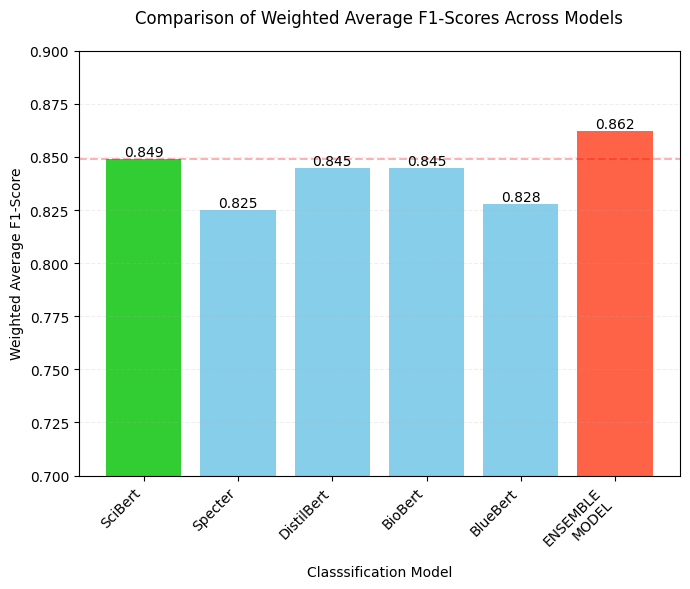

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Data
models = [
    "SciBert",
    "Specter",
    "DistilBert",
    "BioBert",
    "BlueBert",
    "ENSEMBLE\nMODEL"
]

f1_scores = [0.849, 0.825, 0.845, 0.845, 0.828, 0.862]

colors = []
for model in models:
    if "SciBert" in model:
        colors.append('limegreen')  
    elif "ENSEMBLE" in model:
        colors.append('tomato')  
    else:
        colors.append('skyblue')  

# Create figure
plt.figure(figsize=(7, 6))
bars = plt.bar(models, f1_scores, color=colors)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Customize plot
plt.title('Comparison of Weighted Average F1-Scores Across Models', pad=20)
plt.ylabel('Weighted Average F1-Score')
plt.xlabel('Classsification Model')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0.849, color='r', linestyle='--', alpha=0.3)
plt.ylim(0.7, 0.9)  
plt.grid(axis='y', linestyle='--', alpha=0.2)  
plt.tight_layout()

plt.show()

## `ENSEMBLE model inferences - for majority voting - test set - 244 GT`

In [17]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from collections import Counter

# Model paths dictionary
model_paths = {
    'biobert_model': '../cc25k/models/biobert_model',
    'distibert_model': '../cc25k/models/distibert_model',
    'repro_model': '../cc25k/models/repro_model',
    'bluebert_model': '../cc25k/models/bluebert_model',
    'specter_model': '../cc25k/models/specter_model'
}

# Load test data
df = pd.read_csv("../cc25k/selected_random_sample_manually_labelled.csv")  # ensure it has 'input_context' and 'lemos_label'
texts = df["input_context"].tolist()
true_labels = df["lemos_label"].tolist()

# Label mapping
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
reverse_label_map = {v: k for k, v in label_map.items()}  # {"Negative": 0, "Neutral": 1, "Positive": 2}

# Convert string labels to integers
true_labels = [reverse_label_map[label] for label in true_labels]

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inference for each model
for model_name, model_path in model_paths.items():
    print(f"Running inference with {model_name}...")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()

    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1).cpu()
        preds = torch.argmax(probs, dim=1).numpy()
        confidences = probs.max(dim=1).values.numpy()

    df[f"pred_{model_name}"] = preds
    df[f"confidence_{model_name}"] = confidences


def majority_vote(row):
    votes = []
    for model_name in model_paths:
        if row[f"confidence_{model_name}"] > 0.99:
            votes.append(row[f"pred_{model_name}"])
    if votes:
        return Counter(votes).most_common(1)[0][0]
    else:
        return -1  

df["majority_vote"] = df.apply(majority_vote, axis=1)

# Replace -1 majority votes with repro_model prediction
df["majority_vote"] = df.apply(
    lambda row: row["pred_repro_model"] if row["majority_vote"] == -1 else row["majority_vote"],
    axis=1
)

# Classification report on confident predictions
valid_df = df[df["majority_vote"] != -1]
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
target_names = [label_map[i] for i in sorted(label_map)]
print("Classification Report (confident majority votes only):")
print(classification_report(true_labels, valid_df["majority_vote"], target_names=target_names,digits=3 ))

# # Reorder columns: text, label, then interleaved pred/conf for each model, then majority_vote
# cols = ["text", "label"]
# for model_name in model_paths:
#     cols.append(f"pred_{model_name}")
#     cols.append(f"confidence_{model_name}")
# cols.append("majority_vote")
# df = df[cols]

# # Save to CSV
# output_path = "cc25k/extend_cc25k/test_ensemble_predictions.csv"
# df.to_csv(output_path, index=False)
# print(f"Saved predictions and majority vote to {output_path}")


Running inference with biobert_model...
Running inference with distibert_model...
Running inference with repro_model...
Running inference with bluebert_model...
Running inference with specter_model...
Classification Report (confident majority votes only):
              precision    recall  f1-score   support

    Negative      0.724     1.000     0.840        55
     Neutral      0.909     0.575     0.704        87
    Positive      0.832     0.922     0.874       102

    accuracy                          0.816       244
   macro avg      0.822     0.832     0.806       244
weighted avg      0.835     0.816     0.806       244



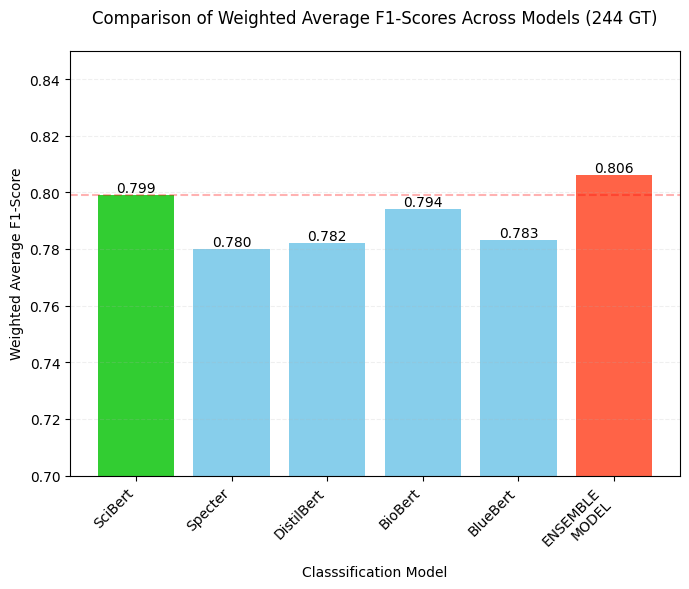

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Data
models = [
    "SciBert",
    "Specter",
    "DistilBert",
    "BioBert",
    "BlueBert",
    "ENSEMBLE\nMODEL"
]

f1_scores = [0.799, 0.780, 0.782, 0.794, 0.783, 0.806]

colors = []
for model in models:
    if "SciBert" in model:
        colors.append('limegreen')  
    elif "ENSEMBLE" in model:
        colors.append('tomato')  
    else:
        colors.append('skyblue')  

# Create figure
plt.figure(figsize=(7, 6))
bars = plt.bar(models, f1_scores, color=colors)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Customize plot
plt.title('Comparison of Weighted Average F1-Scores Across Models (244 GT)', pad=20)
plt.ylabel('Weighted Average F1-Score')
plt.xlabel('Classsification Model')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=f1_scores[0], color='r', linestyle='--', alpha=0.3)
plt.ylim(0.7, 0.85)  
plt.grid(axis='y', linestyle='--', alpha=0.2)  
plt.tight_layout()

plt.show()

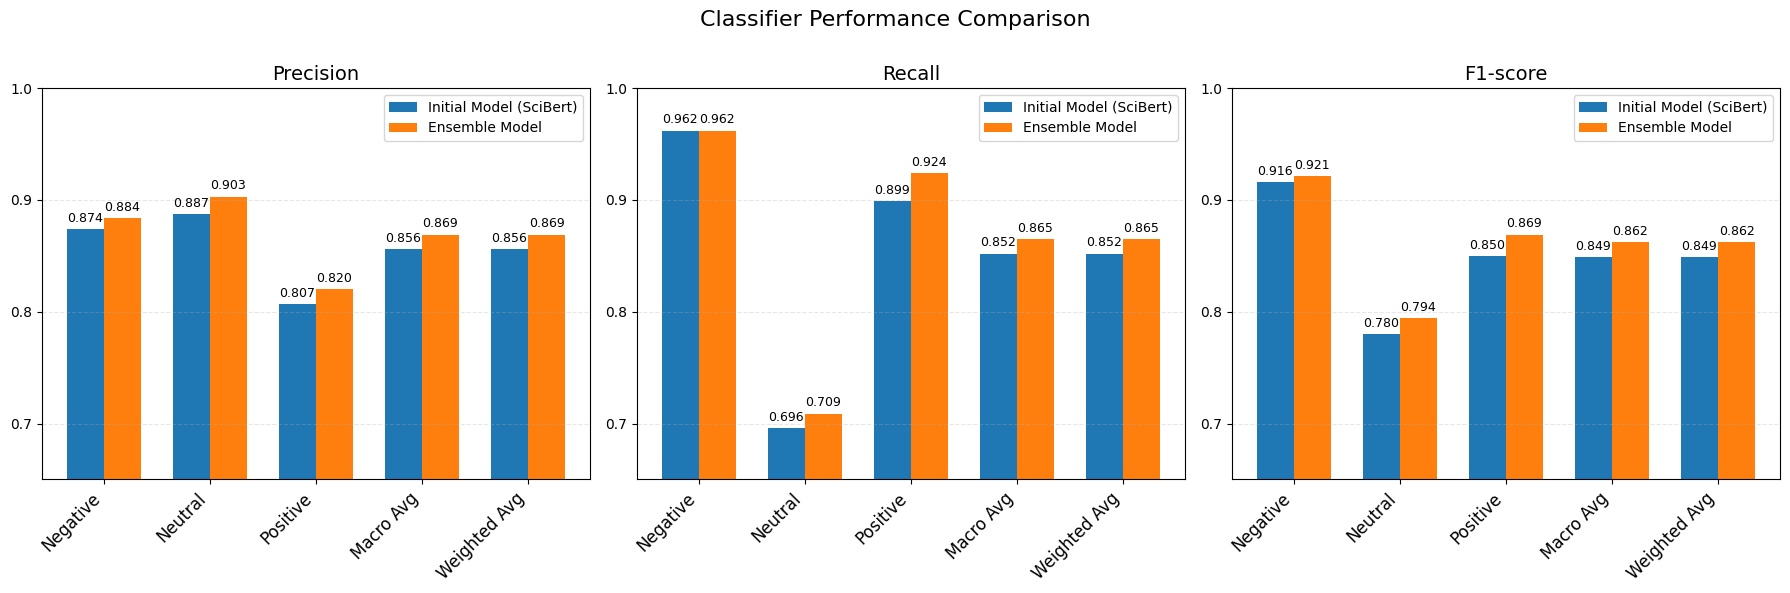

In [51]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['Negative', 'Neutral', 'Positive', 'Macro Avg', 'Weighted Avg']
metrics = ['precision', 'recall', 'f1-score']

initial_data = {
    'precision': [0.874, 0.887, 0.807, 0.856, 0.856],
    'recall': [0.962, 0.696, 0.899, 0.852, 0.852],
    'f1-score': [0.916, 0.780, 0.850, 0.849, 0.849]
}

ensemble_data = {
    'precision': [0.884, 0.903, 0.820, 0.869, 0.869],
    'recall': [0.962, 0.709, 0.924, 0.865, 0.865],
    'f1-score': [0.921, 0.794, 0.869, 0.862, 0.862]
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Classifier Performance Comparison', fontsize=16)

colors = {'initial': '#1f77b4', 'ensemble': '#ff7f0e'}

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, initial_data[metric], width, 
                  label='Initial Model (SciBert)', color=colors['initial'])
    bars2 = ax.bar(x + width/2, ensemble_data[metric], width, 
                  label='Ensemble Model', color=colors['ensemble'])
    
    ax.set_title(metric.capitalize(), fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12)
    ax.set_ylim(0.65, 1.0)  
    ax.set_yticks(np.arange(0.7, 1.05, 0.1))
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.legend(fontsize=10)
    
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(top=0.85)  
plt.show()

# LLM predictions

In [19]:
training_data = {
    "positive": [
        {
            "text": "Our work is built upon the official setup of EFDMix (Zhang et al., 2022).",
            "reasoning": "The authors explicitly state that their work builds upon the official setup of a cited method, indicating use and reuse of reproducible resources."
        },
        {
            "text": "For LC estimation, we use Monte Carlo (MC) approach (Yan & Procaccia, 2020) as the baseline.",
            "reasoning": "The cited method is actively used as a baseline in the current work, suggesting its reproducibility and applicability."
        },
        {
            "text": "We initialize weights using MIM pre-trained models, and fine-tune on ImageNet-1K with class label, similar to [8, 12, 9].",
            "reasoning": "The citation is associated with using pre-trained models in the current pipeline, reflecting a reproducibility-supportive use of prior work."
        },
        {
            "text": "The loss is computed in a pixel-by-pixel manner, the same as MAE [30].",
            "reasoning": "This indicates that the method described in the cited work is replicated for loss computation, showing reproducibility in practice."
        },
        {
            "text": "Following the recent masked target prediction-based SSL model (He et al. 2022), we build an SSL model suitable for video summarization tasks with an adaptation of asymmetric encoder-decoder design.",
            "reasoning": "The citation is acknowledged as a foundation for extending or adapting its method, showing reproducibility and further development of prior work."
        }
    ],
    "neutral": [
        {
            "text": "Although dating from 2015, VGG-19 is still the go-to architecture for applications involving Gram matrices such as image style transfer (Zhang et al., 2022; Hllein et al., 2022; Xie et al., 2022).",
            "reasoning": "This citation refers to general popularity or historical usage of the model, without any specific reproduction or reuse of the implementation."
        },
        {
            "text": "In vision-and-language tasks, there has been some recent advancements, especially for image captioning [21, 23, 47, 59].",
            "reasoning": "The citations are used to point out general progress in a subfield, not tied to any reuse or validation of prior work."
        },
        {
            "text": "In addition, prominent examples in HCCV research demonstrate disparate algorithmic performance based on race and skin color [106, 293, 125, 327, 217, 34, 33, 261, 236, 44, 122].",
            "reasoning": "The cited works are listed as examples to illustrate a trend, not because they were reproduced or tested in this paper."
        },
        {
            "text": "In recent years, supervised learning methods have made remarkable advancements in computer vision (CV), natural language processing (NLP), and human-level game playing [1, 2, 3, 4, 5, 6, 7].",
            "reasoning": "This is a broad, field-level summary citing well-known results without referencing any attempts to reproduce or evaluate them."
        },
        {
            "text": "Contrarily, MAE [21] reconstructs raw pixels of the image explicitly",
            "reasoning": "The citation is used to describe the original method’s behavior, without indicating any replication or use of the implementation."
        }
    ],
    "negative": [
        {
            "text": "It was therefore unclear how to get the dataset labels for the tSNE latent space visualization in Figure 4 as it is not mentioned in the paper [1].",
            "reasoning": "The authors attempted to reproduce a result but encountered missing information that hindered reproduction, indicating a reproducibility failure."
        },
        {
            "text": "Surprisingly, when we directly reconstruct masked joints using a method similar to that in MAE [10], the performance degrades instead.",
            "reasoning": "The authors tried to replicate an approach from the cited paper but observed a performance drop, showing an unsuccessful attempt at reproduction."
        },
        {
            "text": "Indeed, we have observed that freezing the backbone and training a linear classifier on top of MAE features perform very poorly [34].",
            "reasoning": "An experimental attempt based on the cited method led to poor performance, suggesting issues with reproducing the reported results."
        },
        {
            "text": "On the other hand, if importing the AdaBelief (Zhuang et al., 2020) code fails, the module will not be registered and therefore not be available in the graphical user interface.",
            "reasoning": "This notes a failure in integrating the cited code due to import issues, which highlights a breakdown in reproducibility due to implementation problems."
        },
        {
            "text": "We also tried MBPO [35], but we found that this method takes too much memory and could not finish any test.",
            "reasoning": "The cited method was tried but could not be executed due to resource constraints, indicating a failed attempt to reproduce it."
        }
    ]
}


In [29]:
import pandas as pd
import openai
import anthropic
import random
import os
import re
import time
from sklearn.metrics import classification_report
from tqdm import tqdm


# === API KEYS ===
openai.api_key = ""
anthropic_client = anthropic.Anthropic(api_key="")

VALID_LABELS = {"positive", "neutral", "negative"}


def build_prompt(sample, technique, k=1, cot=False):
    """
    Build a prompt for GPT or Claude to classify reproducibility-oriented sentiment.

    Args:
        sample (str): The test sample text to classify.
        technique (str): Name of prompting technique ("1-shot", "3-shot", etc.).
        k (int): Number of examples per class to include.
        cot (bool): Whether to use chain-of-thought (CoT) prompting.

    Returns:
        str: The complete prompt.
    """
    intro = (
        "You are a helpful assistant trained to classify citation contexts from scholarly articles into one of three reproducibility-oriented sentiment categories. "
        "Your task is to choose the most appropriate category (label) from the three provided options for a given citation context that reflects the reproducibility of the cited paper.\n\n"
        "- positive: Containing positive reproducibility effort related words like reproduce, replicate, or repeat the experiments OR the software/process was used for preprocessing or comparison\n"
        "- neutral: Simply mentioning the cited paper without any attempts to run the implementation or verify the results\n"
        "- negative: An unsuccessful attempt to reproduce the reported results OR an unsuccessful attempt to redo the experiments due to the unavailability of resources\n"
    )

    shots = []
    for label in ["positive", "neutral", "negative"]:
        examples = training_data[label][:k]
        for ex in examples:
            if cot:
                shot = (
                    f"Text: \"{ex['text']}\"\n"
                    f"Reasoning: {ex['reasoning']}\n"
                    f"Sentiment: {label}"
                )
            else:
                shot = (
                    f"Text: \"{ex['text']}\"\n"
                    f"Sentiment: {label}"
                )
            shots.append(shot)

    shots_text = "\n\n".join(shots)

    if cot:
        prompt = (
            f"{intro}\n\n"
            f"Here are some examples with reasoning:\n\n"
            f"{shots_text}\n\n"
            f"Now classify the following and no need to output your reasoning:\n"
            f"Text: \"{sample}\"\n"
            f"Sentiment:"
        )
    else:
        prompt = (
            f"{intro}\n\n"
            f"Here are some examples:\n\n"
            f"{shots_text}\n\n"
            f"Now classify the following:\n"
            f"Text: \"{sample}\"\n"
            f"Sentiment:"
        )

    return prompt



# === MODEL CALLS ===
def classify_gpt4o(prompt):
    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"ERROR: {e}"

def classify_claude(prompt):
    try:
        response = anthropic_client.messages.create(
            model="claude-3-opus-20240229",
            max_tokens=512,
            temperature=0,
            messages=[{"role": "user", "content": prompt}]
        )
        return response.content[0].text.strip()
    except Exception as e:
        return f"ERROR: {e}"


def extract_clean_label(response_text):
    """
    Extract a single valid label from a possibly verbose response.
    Only one of ['positive', 'neutral', 'negative'] is allowed.
    """
    text = response_text.lower().strip()

    match = re.search(r"sentiment\s*:\s*(positive|neutral|negative)", text)
    if match:
        return match.group(1)

    for label in VALID_LABELS:
        if label in text:
            return label

    return "neutral"

# === MAIN FUNCTION
def classify_and_evaluate(input_csv, output_csv, report_dir=r"cc25k/extend_cc25k/llms"):
    
    os.makedirs(report_dir, exist_ok=True)
    
    df = pd.read_csv(input_csv)
    techniques = {
        "1-shot": 1,
        "3-shot": 3,
        "5-shot": 5,
        "CoT": 5
    }

    all_predictions = []  # To collect predictions for report
    all_results = []      # To write back to CSV

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        # print(idx)
        sample = row["input_context"]
        ground_truth = row["majority_vote"].strip().lower()
        result_row = {"text": sample, "label": ground_truth}
        preds = {"label": ground_truth}

        for model_name, model_fn in {
            "gpt4o": classify_gpt4o,
            "claude": classify_claude
        }.items():
            print(f"\n---------{model_name.upper()}---------\n")
            for technique, k in techniques.items():
                print(f"{technique.upper()}")
                cot = (technique == "CoT")
                prompt = build_prompt(sample, technique, k=k, cot=cot)
    
                # print(prompt)
            

                raw_pred = model_fn(prompt)
                label = extract_clean_label(raw_pred)
                key = f"{model_name}_{technique}"
                preds[key] = label
                result_row[key] = raw_pred  # save raw model output


        all_predictions.append(preds)
        all_results.append(result_row)

        if idx % 25 ==0:
            time.sleep(2)
        if idx == 2:
            break

    # # Save CSV with raw predictions
    pd.DataFrame(all_predictions).to_csv(output_csv, index=False)
    print(f"✅ Saved detailed results to {output_csv}")

    # Generate classification reports
    for model_name in ["gpt4o", "claude"]:
        for technique in techniques.keys():
            key = f"{model_name}_{technique}"
            y_true = [p["label"] for p in all_predictions]
            y_pred = [p[key] for p in all_predictions]
            report = classification_report(y_true, y_pred, output_dict=False)
            print(f"\n📊 Classification Report: {key}\n{report}")

            with open(f"{report_dir}/{key}_report.txt", "w") as f:
                f.write(f"Classification Report for {key}\n")
                f.write(report)

# === USAGE ===
classify_and_evaluate(r"cc25k/test.csv", r"cc25k/extend_cc25k/LLM_classified_outputs.csv")

  0%|          | 0/237 [00:00<?, ?it/s]

---------GPT4O---------

1-SHOT

3-SHOT

5-SHOT

COT



---------CLAUDE---------

1-SHOT

3-SHOT

5-SHOT

COT





  0%|          | 1/237 [00:15<1:00:32, 15.39s/it]

---------GPT4O---------

1-SHOT

3-SHOT

5-SHOT

COT



---------CLAUDE---------

1-SHOT

3-SHOT

5-SHOT

COT


  1%|          | 2/237 [00:28<54:21, 13.88s/it]  




---------GPT4O---------

1-SHOT

3-SHOT

5-SHOT

COT



---------CLAUDE---------

1-SHOT

3-SHOT

5-SHOT

COT


  1%|          | 2/237 [00:40<1:18:28, 20.04s/it]




✅ Saved detailed results to cc25k/extend_cc25k/LLM_classified_outputs.csv

📊 Classification Report: gpt4o_1-shot
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
     neutral       0.50      1.00      0.67         1
    positive       1.00      1.00      1.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3


📊 Classification Report: gpt4o_3-shot
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
     neutral       0.50      1.00      0.67         1
    positive       1.00      1.00      1.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3


📊 Classification Report: gpt4o_5-shot
              precision    recall  f1-score 


/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

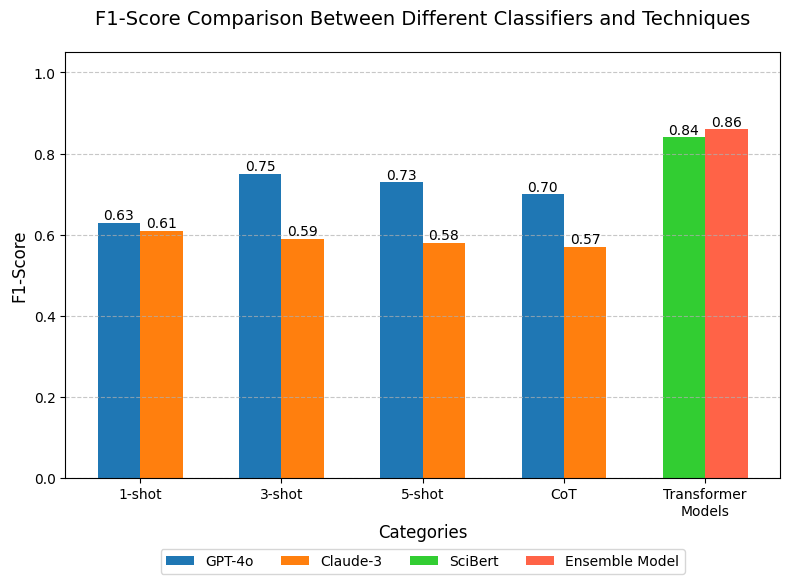

In [3]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Categories for the main models
main_categories = ['1-shot', '3-shot', '5-shot', 'CoT']
gpt4 = [0.63, 0.75, 0.73, 0.70]
claude = [0.61, 0.59, 0.58, 0.57]

# Comparison models
comparison_label = 'Transformer\nModels'
model_x = 0.84
model_y = 0.86

# Plot setup
plt.figure(figsize=(8, 6))
width = 0.3

# X positions
x_main = np.arange(len(main_categories))
x_compare = len(main_categories)  

# Plot main bars
bars1 = plt.bar(x_main - width/2, gpt4, width, label='GPT-4o', color='#1f77b4')
bars2 = plt.bar(x_main + width/2, claude, width, label='Claude-3', color='#ff7f0e')

# Plot comparison bars separately
bars3 = plt.bar(x_compare - width/2, model_x, width, label='SciBert', color='limegreen')
bars4 = plt.bar(x_compare + width/2, model_y, width, label='Ensemble Model', color='tomato')

# X-axis tick positions and labels
xticks = list(x_main) + [x_compare]
xlabels = main_categories + [comparison_label]
plt.xticks(xticks, xlabels)

# Add value labels on all bars
for bar_container in [bars1, bars2, bars3, bars4]:
    for bar in bar_container.patches:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}', ha='center', va='bottom')

# Plot formatting
plt.title('F1-Score Comparison Between Different Classifiers and Techniques', fontsize=14, pad=20)
plt.xlabel('Categories', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

plt.tight_layout()
plt.show()


# using ensmble model to predict negative citation contexts

## `new negative contexts from majority voting`

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from collections import Counter
import csv
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model paths
model_paths = {
    'biobert_model': 'cc25k/models/biobert_model',
    'distibert_model': 'cc25k/models/distibert_model',
    'repro_model': 'cc25k/models/repro_model',
    'bluebert_model': 'cc25k/models/bluebert_model',
    'specter_model': 'cc25k/models/specter_model'
}

# Parameters
chunk_size = 1000           # rows to read from CSV at once
gpu_batch_size = 16         # number of texts to send to GPU at a time
confidence_threshold = 0.90
input_csv = "cc25k/extend_cc25k/all_in_one_citation_contexts.csv"
output_csv = "cc25k/extend_cc25k/negative_majority_ensemble.csv"

# Prepare output file
with open(output_csv, mode='w', newline='', encoding='utf-8') as f_out:
    writer = csv.writer(f_out)
    writer.writerow(["context", "majority_vote"])

# Estimate total lines for tqdm
total_rows = sum(1 for _ in open(input_csv, encoding='utf-8')) - 1

# Chunked processing
reader = pd.read_csv(input_csv, chunksize=chunk_size)

with tqdm(total=total_rows, desc="Processing contexts", unit="context") as pbar:
    for chunk in reader:
        texts = chunk["context"].tolist()
        n = len(texts)
        predictions_per_model = {}

        for model_name in tqdm(model_paths, desc="Model predictions", leave=False):
            # Load model/tokenizer
            tokenizer = AutoTokenizer.from_pretrained(model_paths[model_name])
            model = AutoModelForSequenceClassification.from_pretrained(model_paths[model_name])
            model.to(device)
            model.eval()

            preds_all = []
            confs_all = []

            for i in range(0, n, gpu_batch_size):
                batch_texts = texts[i:i + gpu_batch_size]

                inputs = tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=512,
                    return_tensors="pt"
                )
                inputs = {k: v.to(device) for k, v in inputs.items()}

                with torch.no_grad():
                    outputs = model(**inputs)
                    probs = F.softmax(outputs.logits, dim=1).cpu()
                    preds = torch.argmax(probs, dim=1).numpy()
                    confs = probs.max(dim=1).values.numpy()

                preds_all.extend(preds)
                confs_all.extend(confs)

            predictions_per_model[model_name] = (preds_all, confs_all)

            # Free GPU memory
            del model
            torch.cuda.empty_cache()

        # Majority voting
        majority_votes = []
        for idx in range(n):
            votes = []
            for model_name in model_paths:
                pred = predictions_per_model[model_name][0][idx]
                conf = predictions_per_model[model_name][1][idx]
                if conf > confidence_threshold:
                    votes.append(pred)

            if votes:
                majority = Counter(votes).most_common(1)[0][0]
            else:
                majority = predictions_per_model["repro_model"][0][idx]

            majority_votes.append((texts[idx], majority))

        # Save negative-only
        negative_rows = [(text, vote) for text, vote in majority_votes if vote == 0]
        with open(output_csv, mode='a', newline='', encoding='utf-8') as f_out:
            writer = csv.writer(f_out)
            writer.writerows(negative_rows)

        pbar.update(n)

Processing contexts:   2%|▏         | 15000/733256 [03:04<2:27:36, 81.10context/s]


KeyboardInterrupt: 

In [2]:
input_path = "cc25k/extend_cc25k/all_in_one_citation_contexts.csv"

df = pd.read_csv(input_path)
len(df)

692604

In [3]:
output_path = "cc25k/extend_cc25k/all_in_one_with_majority_vote.csv"

df = pd.read_csv(output_path)
len(df)

43790

# Binary Classifier for Citation Context "Negative" Reproducibility-Oriented Sentiment Classification 

## `preparing the dataset`
Fine-tune a Hugging Face transformer model to classify citation contexts as negative, not_negative reproducibility sentiment.

In [1]:
!pip install transformers datasets scikit-learn

## `prepare the initial dataset`

In [7]:
import pandas as pd
df_ = pd.read_csv(r'cc25k/extend_cc25k/negative_verfied_1055.csv')

In [46]:
df_.head(4)

,cited_paper_id,context,isInfluential,citing_paperId,citing_paper_title,citing_paper_year,citing_paper_publicationVenue,citing_paper_author_names,pred_biobert_model,confidence_biobert_model,...,pred_repro_model,confidence_repro_model,pred_bluebert_model,confidence_bluebert_model,pred_specter_model,confidence_specter_model,majority_vote,actually_negative,row highlight,All negatives: 1055
0,cbd7393854884959fe561a8425d34955029fbadf,Career decision making is an individual’s choi...,False,5e296a482af66b9c31740b5897a6c565050945fe,Deciding Alone or with Others: Employment Anxi...,2023.0,International Journal of Environmental Researc...,"Xiaoli Shu, Jun Peng, Gui-Shu Wang",0,0.642989,...,0,0.970335,0,0.977773,1,0.991385,0,False,True,NaN
1,5826d8f3fb3ccd79cfaf292bb0ddc5eebc13a580,"For example, classifying subcategories of ASSA...",False,30349f90579e43e16ab8ec186756972cef76d369,Leveraging Codebook Knowledge with NLI and Cha...,2023.0,Annual Meeting of the Association for Computat...,"Yibo Hu, Eric Parolin, Latif Khan, Patrick T. ...",0,0.976001,...,0,0.976209,0,0.992252,0,0.811555,0,False,True,NaN
2,5826d8f3fb3ccd79cfaf292bb0ddc5eebc13a580,"However, textual entailment could have been co...",True,236375f49e3deb8ee7918c1f5e65175e453deb2e,Rethinking the Event Coding Pipeline with Prom...,2022.0,NaN,"C. Lefebvre, Niklas Stoehr",0,0.992921,...,0,0.988721,0,0.987777,0,0.755429,0,True,False,NaN
3,73ec11e398f52d29f6866c58e5ba0bd935264e95,"Alternatively, penetrance estimates for most g...",False,507be7a1c111df5ca04038fa7342e47f6dc0d070,Reduced Penetrance is Common Among Predicted L...,2024.0,medRxiv,"D. R. Blair, N. Risch",0,0.990263,...,0,0.993473,0,0.986165,0,0.996029,0,True,False,NaN


In [8]:
df_.columns

Index(['cited_paper_id', 'context', 'isInfluential', 'citing_paperId',
       'citing_paper_title', 'citing_paper_year',
       'citing_paper_publicationVenue', 'citing_paper_author_names',
       'pred_biobert_model', 'confidence_biobert_model',
       'pred_distibert_model', 'confidence_distibert_model',
       'pred_repro_model', 'confidence_repro_model', 'pred_bluebert_model',
       'confidence_bluebert_model', 'pred_specter_model',
       'confidence_specter_model', 'majority_vote', 'actually_negative',
       'row highlight', 'All negatives: 1055'],
      dtype='object')

In [9]:
import numpy as np
df_contexts = df_[['context', 'actually_negative']].iloc[np.r_[0:3006, 5000:7572]]

df_negative_sampled = df_contexts[df_contexts['actually_negative']==True]
df_positive_sampled = df_contexts[df_contexts['actually_negative']==False].sample(n=1055, random_state=42)

df_negative_sampled['label_lemos'] = 'negative' 
df_positive_sampled['label_lemos'] = 'not_negative' 

df_negative_sampled

/tmp/ipykernel_934714/2943488122.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negative_sampled['label_lemos'] = 'negative'


,context,actually_negative,label_lemos
2,"However, textual entailment could have been co...",True,negative
3,"Alternatively, penetrance estimates for most g...",True,negative
6,They also don’t make a concession of variant c...,True,negative
7,…missing best practice recommendations—most im...,True,negative
9,…urgently demand rigorous cataloging and asses...,True,negative
...,...,...,...
7470,"However, existing computational approaches are...",True,negative
7492,"(4) (cf. [16, 17]), but these studies are outs...",True,negative
7504,"However, other than recent work limited to the...",True,negative
7527,"However, these methods struggle with generaliz...",True,negative


In [10]:
import pandas as pd

def split_train_test(df, label_name):
    df = df.sample(frac=1, random_state=42).reset_index(drop=False)  # shuffle
    df_train = df.iloc[: 905].copy()
    df_test = df.iloc[905:].copy()
    
    return df_train, df_test

# Split each class
train_neg, test_neg = split_train_test(df_negative_sampled, "negative")
train_pos, test_pos = split_train_test(df_positive_sampled, "not_negative")

# combine splits
train_df = pd.concat([train_neg, train_pos]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([test_neg, test_pos]).sample(frac=1, random_state=42).reset_index(drop=True)

label_map = {"negative": 0, "not_negative": 1}

# Apply the mapping to both train and test sets
train_df["label"] = train_df["label_lemos"].map(label_map)
test_df["label"] = test_df["label_lemos"].map(label_map)

train_df = train_df.rename(columns={"context": "text"})
test_df = test_df.rename(columns={"context": "text"})

train_df[['text','label']].to_csv(r"cc25k/extend_cc25k/negative_train_minimum.csv", index=False)
test_df[['text','label']].to_csv(r"cc25k/extend_cc25k/negative_test_minimum.csv", index=False)

In [11]:
train_df['label_lemos'].value_counts()

label_lemos
not_negative    905
negative        905
Name: count, dtype: int64

In [12]:
test_df['label_lemos'].value_counts()

label_lemos
not_negative    150
negative        150
Name: count, dtype: int64

## Fine-Tune the Model (SciBERT)

In [23]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
dataset = load_dataset("csv", data_files={"train": r"cc25k/extend_cc25k/negative_train_minimum.csv", 
                                          "validation": r"cc25k/extend_cc25k/negative_train_minimum.csv"})

# Tokenize
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",      
        truncation=True,
        max_length=512,            
    )    

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./cc25k/models/binary_negative_model/results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16, #4
    per_device_eval_batch_size=16,
    num_train_epochs=12,
    weight_decay=0.01,
    warmup_steps=100,
    logging_dir="./cc25k/models/binary_negative_model/logs",
    logging_steps=10,
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Save model
model.save_pretrained(r"cc25k/models/binary_negative_model")
tokenizer.save_pretrained(r"cc25k/models/binary_negative_model")

/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batch

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.684000,0.554340,0.730939,0.751541,0.730939,0.725315
2,0.568600,0.361492,0.871823,0.877399,0.871823,0.871348
3,0.378000,0.289718,0.913812,0.913885,0.913812,0.913808
4,0.429900,0.214016,0.948066,0.948559,0.948066,0.948052
5,0.401000,0.136396,0.962983,0.963600,0.962983,0.962971
6,0.449500,0.059894,0.984530,0.984590,0.984530,0.984530
7,0.017400,0.014078,0.997790,0.997800,0.997790,0.997790
8,0.000400,0.013211,0.998343,0.998348,0.998343,0.998343
9,0.095900,0.012908,0.998343,0.998348,0.998343,0.998343
10,0.000500,0.012450,0.998343,0.998348,0.998343,0.998343


('cc25k/models/binary_negative_model/tokenizer_config.json',
 'cc25k/models/binary_negative_model/special_tokens_map.json',
 'cc25k/models/binary_negative_model/vocab.txt',
 'cc25k/models/binary_negative_model/added_tokens.json',
 'cc25k/models/binary_negative_model/tokenizer.json')

In [38]:
import google.protobuf
print(google.protobuf.__version__)

3.20.3


In [35]:
!pip install protobuf==3.20.3

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [36]:
!pip install accelerate==0.28.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for accelerate==0.28.0 from https://files.pythonhosted.org/packages/a0/11/9bfcf765e71a2c84bbf715719ba520aeacb2ad84113f14803ff1947ddf69/accelerate-0.28.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 11.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install transformers==4.37.2

## `Load Model and Predict on negative_test_minimum - SciBert`

In [11]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cc25k/models/binary_negative_model")
tokenizer = AutoTokenizer.from_pretrained("cc25k/models/binary_negative_model")

# Load test CSV
df = pd.read_csv(r"cc25k/extend_cc25k/negative_test_minimum.csv")  
texts = df["text"].tolist()
true_labels = df["label"].tolist()

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True, #max_length
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()


# Generate classification report
label_map = {0: "negative", 1: "not_negative"}
target_names = [label_map[i] for i in sorted(label_map)]
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


              precision    recall  f1-score   support

    negative      0.602     0.747     0.667       150
not_negative      0.667     0.507     0.576       150

    accuracy                          0.627       300
   macro avg      0.634     0.627     0.621       300
weighted avg      0.634     0.627     0.621       300



## `using GPT-4o`

In [1]:
import pandas as pd
import re
import os
from sklearn.metrics import classification_report
from openai import OpenAI
from dotenv import load_dotenv

# Load API key
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# ===== Config =====
test_file = r"cc25k/extend_cc25k/negative_test_minimum.csv"  
output_file = r"cc25k/extend_cc25k/negative_test_minimum_gpt4o_predictions.csv"
VALID_LABELS = {'negative', 'not_negative'}

# ===== Load test data =====
df_test = pd.read_csv(test_file)

df_test["label_lemos"] = df_test["label"].apply(
    lambda x: "negative" if x == 0 else "not_negative"
)

# Load few-shot examples
df_train = pd.read_csv(r"cc25k/extend_cc25k/negative_train_minimum.csv")  

df_train["label_lemos"] = df_train["label"].apply(
    lambda x: "negative" if x == 0 else "not_negative"
)

NEGATIVE_SAMPLES = df_train[df_train["label_lemos"].str.lower() == "negative"].sample(n=3, random_state=42)
NOT_NEGATIVE_SAMPLES = df_train[df_train["label_lemos"].str.lower() == "not_negative"].sample(n=3, random_state=42)


few_shot_examples = []
for _, row in pd.concat([NEGATIVE_SAMPLES, NOT_NEGATIVE_SAMPLES]).iterrows():
    few_shot_examples.append((row["text"], row["label_lemos"].lower()))

def build_prompt(context):
    base = (
        "You are a helpful assistant that classifies scientific citation contexts as either "
        "'negative' or 'not_negative' based on the following definitions:\n\n"
        "- negative: The context hints at irreproducibility or irreplicability, such as the unavailability "
        "of the cited paper’s data or code, or unsuccessful attempts to reproduce the results.\n"
        "- not_negative: The context does not indicate irreproducibility.\n\n"
        "Respond only with one of the labels: negative or not_negative.\n\n"
    )

    # Insert few-shot examples
    base += "Here are some examples:\n"
    for i, (ex_text, ex_label) in enumerate(few_shot_examples, start=1):
        base += f"Example {i}:\nCitation Context: {ex_text}\nLabel: {ex_label}\n\n"

    # Append the new context to classify
    base += f"Citation Context:\n{context}\n\nAnswer:"
    return base


def extract_clean_label(response_text):
    matches = re.findall(r'(negative|not_negative)', response_text, re.IGNORECASE)
    if matches:
        return matches[-1].lower()
    return "---"

# ===== Run inference =====
predictions = []
raw_predictions = []

for context in df_test["text"]:
    prompt = build_prompt(context)
    try:
        completion = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=10
        )
        generated = completion.choices[0].message.content.strip()
    except Exception as e:
        generated = f"ERROR: {e}"
    
    label = extract_clean_label(generated)
    predictions.append(label)
    raw_predictions.append(generated)

# ===== Evaluation =====
df_test["predicted"] = predictions
df_test["raw_predictions"] = raw_predictions

report = classification_report(
    df_test["label_lemos"].str.lower(),
    df_test["predicted"].str.lower(),
    labels=["negative", "not_negative"],
    target_names=["negative", "not_negative"],
    digits=3
)

print(report)
print("GPT-4o binary classification results")

              precision    recall  f1-score   support

    negative      0.703     0.300     0.421       150
not_negative      0.555     0.873     0.679       150

    accuracy                          0.587       300
   macro avg      0.629     0.587     0.550       300
weighted avg      0.629     0.587     0.550       300

GPT-4o binary classification results


In [3]:
print("GPT-4o binary classification results")
print(report)

GPT-4o binary classification results
              precision    recall  f1-score   support

    negative      0.703     0.300     0.421       150
not_negative      0.555     0.873     0.679       150

    accuracy                          0.587       300
   macro avg      0.629     0.587     0.550       300
weighted avg      0.629     0.587     0.550       300



In [2]:
df_test.to_csv(r'cc25k/extend_cc25k/negative_test_minimum_gpt4o_predictions.csv')

## Fine-Tune the Model (RoBERTa)

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import re


dataset = load_dataset(
    "csv", 
    data_files={
        "train": r"cc25k/extend_cc25k/negative_train_minimum.csv", 
        "validation": r"cc25k/extend_cc25k/negative_train_minimum.csv"
    }
)

# Tokenize
model_name = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",      
        truncation=True,
        max_length=512,            
    )    

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./cc25k/models/binary_negative_model_roberta/results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16, #4
    per_device_eval_batch_size=16,
    num_train_epochs=8, #12
    weight_decay=0.01,
    warmup_steps=100,
    logging_dir="./cc25k/models/binary_negative_model_roberta/logs",
    logging_steps=10,
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Save model
model.save_pretrained(r"cc25k/models/binary_negative_model_roberta")
tokenizer.save_pretrained(r"cc25k/models/binary_negative_model_roberta")

/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-08-19 17:13:06.773021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.717500,0.681436,0.546961,0.665595,0.546961,0.448118
2,0.595000,0.484899,0.787845,0.794297,0.787845,0.786676
3,0.518800,0.359273,0.862431,0.876509,0.862431,0.861133
4,0.406100,0.229839,0.913812,0.923663,0.913812,0.913308
5,0.229800,0.097617,0.969061,0.970073,0.969061,0.969044
6,0.156000,0.062414,0.986188,0.986402,0.986188,0.986186
7,0.051100,0.052176,0.986188,0.986450,0.986188,0.986186
8,0.071300,0.039555,0.992265,0.992304,0.992265,0.992265


Checkpoint destination directory ./cc25k/models/binary_negative_model_roberta/results/checkpoint-114 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./cc25k/models/binary_negative_model_roberta/results/checkpoint-228 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./cc25k/models/binary_negative_model_roberta/results/checkpoint-342 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./cc25k/models/binary_negative_model_roberta/results/checkpoint-456 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./cc25k/models/binary_negative_model_roberta/results/checkpoint-570 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./cc25k/models/binary_negative_m

('cc25k/models/binary_negative_model_roberta/tokenizer_config.json',
 'cc25k/models/binary_negative_model_roberta/special_tokens_map.json',
 'cc25k/models/binary_negative_model_roberta/vocab.json',
 'cc25k/models/binary_negative_model_roberta/merges.txt',
 'cc25k/models/binary_negative_model_roberta/added_tokens.json',
 'cc25k/models/binary_negative_model_roberta/tokenizer.json')

In [35]:
!pip install protobuf==3.20.3

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [37]:
!pip install transformers==4.37.2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for transformers==4.37.2 from https://files.pythonhosted.org/packages/85/f6/c5065913119c41ecad148c34e3a861f719e16b89a522287213698da911fc/transformers-4.37.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 45.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## `Load Model and Predict on negative_test_minimum - RoBERTa`

In [13]:
# !pip install scikit-learn

In [8]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cc25k/models/binary_negative_model_roberta")
tokenizer = AutoTokenizer.from_pretrained("cc25k/models/binary_negative_model_roberta")

# Load test CSV
df = pd.read_csv(r"cc25k/extend_cc25k/negative_test_minimum.csv") 
texts = df["text"].tolist()
true_labels = df["label"].tolist()

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True, #max_length
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()


# Generate classification report
label_map = {0: "negative", 1: "not_negative"}
target_names = [label_map[i] for i in sorted(label_map)]
print("Roberta binary classification results\n")
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


Roberta binary classification results

              precision    recall  f1-score   support

    negative      0.648     0.700     0.673       150
not_negative      0.674     0.620     0.646       150

    accuracy                          0.660       300
   macro avg      0.661     0.660     0.659       300
weighted avg      0.661     0.660     0.659       300



## Fine-Tune the Model (distilbert)

In [8]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
dataset = load_dataset("csv", data_files={"train": r"cc25k/extend_cc25k/negative_train_minimum.csv", 
                                          "validation": r"cc25k/extend_cc25k/negative_train_minimum.csv"})

# Tokenize
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",     
        truncation=True,
        max_length=512,            
    )    

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./cc25k/models/binary_negative_model_distilbert/results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16, #4
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    warmup_steps=100,
    logging_dir="./cc25k/models/binary_negative_model_distilbert/logs",
    logging_steps=10,
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Save model
model.save_pretrained(r"cc25k/models/binary_negative_model_distilbert")
tokenizer.save_pretrained(r"cc25k/models/binary_negative_model_distilbert")

/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/1810 [00:00<?, ? examples/s]

Map:   0%|          | 0/1810 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/oruma001/envs/r_001_test/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.712000,0.650040,0.671823,0.671988,0.671823,0.671745
2,0.578100,0.479644,0.783978,0.823693,0.783978,0.777142
3,0.410900,0.267406,0.907182,0.912846,0.907182,0.906863
4,0.264300,0.124223,0.962983,0.964131,0.962983,0.962961
5,0.148000,0.054247,0.988398,0.988446,0.988398,0.988398
6,0.099700,0.046100,0.989503,0.989637,0.989503,0.989502
7,0.017600,0.028705,0.993923,0.993952,0.993923,0.993923
8,0.032600,0.026983,0.994475,0.994497,0.994475,0.994475


('cc25k/models/binary_negative_model_distilbert/tokenizer_config.json',
 'cc25k/models/binary_negative_model_distilbert/special_tokens_map.json',
 'cc25k/models/binary_negative_model_distilbert/vocab.txt',
 'cc25k/models/binary_negative_model_distilbert/added_tokens.json',
 'cc25k/models/binary_negative_model_distilbert/tokenizer.json')

## `Load Model and Predict on negative_test_minimum - DistilBert`

In [13]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cc25k/models/binary_negative_model_distilbert")
tokenizer = AutoTokenizer.from_pretrained("cc25k/models/binary_negative_model_distilbert")

# Load test CSV
df = pd.read_csv(r"cc25k/extend_cc25k/negative_test_minimum.csv")  # ensure it has 'text' and 'label' columns
texts = df["text"].tolist()
true_labels = df["label"].tolist()

# Tokenize the dataset
inputs = tokenizer(
    texts,
    padding=True, #max_length
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Move model and inputs to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()


# Generate classification report
label_map = {0: "negative", 1: "not_negative"}
target_names = [label_map[i] for i in sorted(label_map)]
print("DistilBert binary classification results\n")
print(classification_report(true_labels, preds, target_names=target_names, digits=3))


DistilBert binary classification results

              precision    recall  f1-score   support

    negative      0.607     0.660     0.633       150
not_negative      0.628     0.573     0.599       150

    accuracy                          0.617       300
   macro avg      0.618     0.617     0.616       300
weighted avg      0.618     0.617     0.616       300



## Fine-Tune the Model (DeBERTa)

In [3]:
!pip install sentencepiece

## `Load Model and Predict on negative_test_minimum - DeBERTa`

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from tqdm import tqdm

# Load model and tokenizer
model_name = "cc25k/models/binary_negative_model_deberta"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load test CSV
df = pd.read_csv(r"cc25k/extend_cc25k/negative_test_minimum.csv")  # ensure it has 'text' and 'label' columns

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",  # keeps batch tensors aligned
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": label
        }

# Dataset & DataLoader
dataset = TextDataset(df["text"].tolist(), df["label"].tolist(), tokenizer)
loader = DataLoader(dataset, batch_size=16, shuffle=False)  # adjust batch_size to fit memory

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_preds = []
all_labels = []

# Inference loop
with torch.no_grad():
    for batch in tqdm(loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
label_map = {0: "negative", 1: "not_negative"}
target_names = [label_map[i] for i in sorted(label_map)]

print("DeBERTa binary classification results\n")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=3))


Evaluating: 100%|██████████| 19/19 [00:13<00:00,  1.46it/s]

DeBERTa binary classification results

              precision    recall  f1-score   support

    negative      0.650     0.707     0.677       150
not_negative      0.679     0.620     0.648       150

    accuracy                          0.663       300
   macro avg      0.665     0.663     0.663       300
weighted avg      0.665     0.663     0.663       300



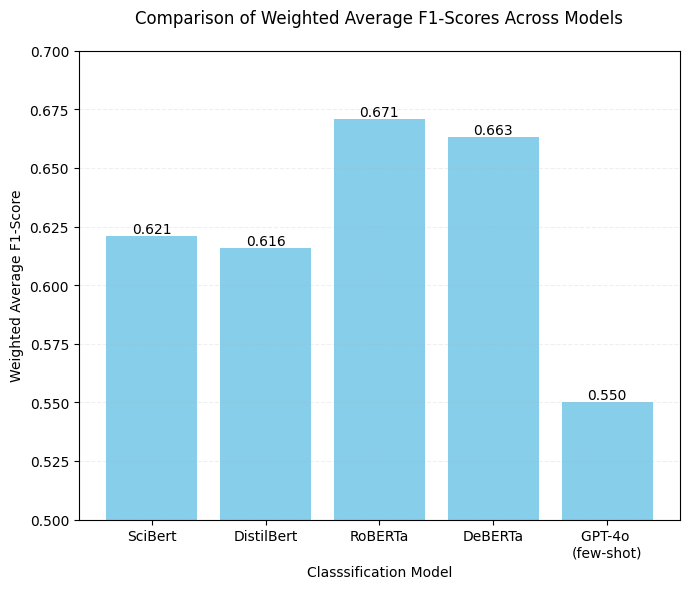

In [8]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Data
models = [
    "SciBert",
    "DistilBert",
    "RoBERTa",
    "DeBERTa",
    "GPT-4o \n(few-shot)"
]

f1_scores = [0.621, 0.616, 0.671, 0.663, 0.550]

# Define colors: Weak Classifier (red), DistillBert (green), others (skyblue)
colors = []
for model in models:
    if "SciBert-" in model:
        colors.append('limegreen')  
    elif "ENSEMBLE" in model:
        colors.append('tomato')
    else:
        colors.append('skyblue')  # Default color

# Create figure
plt.figure(figsize=(7, 6))
bars = plt.bar(models, f1_scores, color=colors)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Customize plot
plt.title('Comparison of Weighted Average F1-Scores Across Models', pad=20)
plt.ylabel('Weighted Average F1-Score')
plt.xlabel('Classsification Model')
plt.xticks(rotation=0, ha='center')
plt.axhline(y=0.849, color='r', linestyle='--', alpha=0.3)
plt.ylim(0.5, 0.7)  # Set y-axis limits to better show differences
plt.grid(axis='y', linestyle='--', alpha=0.2)  # Add light gridlines for readability
plt.tight_layout()

# Show plot
plt.show()

# Filtering actual negative citation contexts

In [28]:
import pandas as pd
df_ = pd.read_csv(r'cc25k/extend_cc25k/negative_verfied_1055.csv')

In [29]:
df_.columns

Index(['cited_paper_id', 'context', 'isInfluential', 'citing_paperId',
       'citing_paper_title', 'citing_paper_year',
       'citing_paper_publicationVenue', 'citing_paper_author_names',
       'pred_biobert_model', 'confidence_biobert_model',
       'pred_distibert_model', 'confidence_distibert_model',
       'pred_repro_model', 'confidence_repro_model', 'pred_bluebert_model',
       'confidence_bluebert_model', 'pred_specter_model',
       'confidence_specter_model', 'majority_vote', 'actually_negative',
       'row highlight', 'All negatives: 1055'],
      dtype='object')

In [36]:
import numpy as np
# df_contexts = df_[['context', 'actually_negative']].iloc[~np.r_[0:3006, 5000:7572]]

# The selected indices
selected_idx = np.r_[0:3006, 5000:7572]

# The inverse: all rows not in selected_idx
df_contexts_inverse = df_.iloc[
    ~df_.index.isin(selected_idx)
]

df_contexts_inverse.head(2)
df_contexts_inverse.to_csv(r"cc25k/extend_cc25k/negative_unlabelled_from_ensemble.csv", index=False)

In [8]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# config
model_path = "cc25k/models/binary_negative_model_roberta"
input_csv = "cc25k/extend_cc25k/negative_unlabelled_from_ensemble.csv"
output_csv = "cc25k/extend_cc25k/negative_new_binary_predicted_confident_contexts.csv"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)



csv_chunk_size = 1000  # How many rows to load from CSV at once
gpu_batch_size = 16     # How many rows to process on GPU at once
confidence_threshold = 0.99

# Load model/tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

header_written = False

# Process CSV in chunks
for chunk in tqdm(pd.read_csv(input_csv, chunksize=csv_chunk_size), desc="Processing CSV Chunks"):
    contexts = chunk["context"].tolist()
    preds_all = []
    confs_all = []

    # Process each GPU batch
    for i in range(0, len(contexts), gpu_batch_size):
        batch_texts = contexts[i:i+gpu_batch_size]

        # Tokenize
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1).cpu()
            preds = torch.argmax(probs, dim=1).numpy()
            confs = probs.max(dim=1).values.numpy()

        preds_all.extend(preds)
        confs_all.extend(confs)

    # Add to DataFrame
    chunk["predicted_label"] = preds_all
    chunk["confidence"] = confs_all

    # Filter and save
    filtered = chunk[(chunk["predicted_label"] == 0) & (chunk["confidence"] > confidence_threshold)]
    if not filtered.empty:
        filtered.to_csv(output_csv, mode='a', index=False, header=not header_written)
        header_written = True

print(f"Done. Filtered predictions saved to {output_csv}")

Processing CSV Chunks: 39it [01:13,  1.89s/it]

Done. Filtered predictions saved to cc25k/extend_cc25k/negative_new_binary_predicted_confident_contexts.csv


In [9]:
output_csv = "cc25k/extend_cc25k/negative_new_binary_predicted_confident_contexts.csv"

final_df = pd.read_csv(output_csv)
len(final_df)

12285

In [44]:
final_df.columns

Index(['cited_paper_id', 'context', 'isInfluential', 'citing_paperId',
       'citing_paper_title', 'citing_paper_year',
       'citing_paper_publicationVenue', 'citing_paper_author_names',
       'pred_biobert_model', 'confidence_biobert_model',
       'pred_distibert_model', 'confidence_distibert_model',
       'pred_repro_model', 'confidence_repro_model', 'pred_bluebert_model',
       'confidence_bluebert_model', 'pred_specter_model',
       'confidence_specter_model', 'majority_vote', 'actually_negative',
       'row highlight', 'All negatives: 1055', 'predicted_label',
       'confidence'],
      dtype='object')

# LLM fine tuning performance visualization 

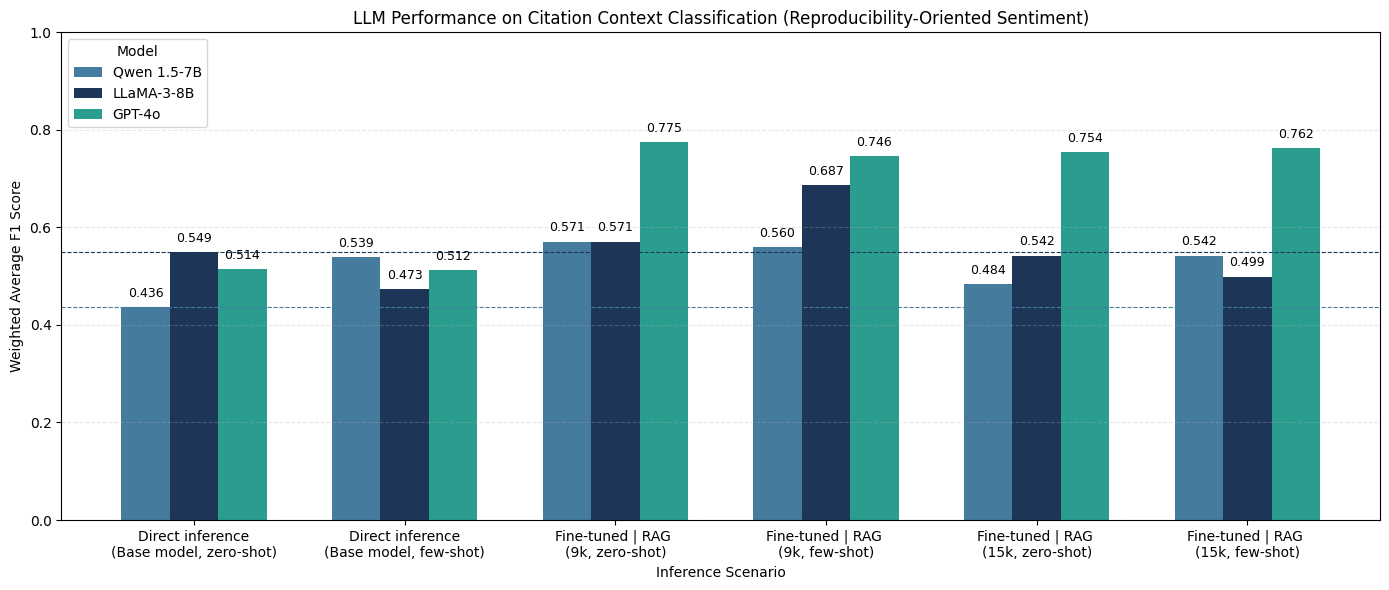

In [7]:
# %matplotlib inline
import matplotlib.pyplot as plt

# Define scenarios and scores
scenarios = [
    "Direct inference\n(Base model, zero-shot)",
    "Direct inference\n(Base model, few-shot)",  # new scenario
    "Fine-tuned | RAG \n(9k, zero-shot)",
    "Fine-tuned | RAG \n(9k, few-shot)",
    "Fine-tuned | RAG \n(15k, zero-shot)",
    "Fine-tuned | RAG \n(15k, few-shot)"
]

qwen_scores  = [0.436, 0.539, 0.571, 0.560, 0.484, 0.542]
llama_scores = [0.549, 0.473, 0.571, 0.687, 0.542, 0.499]
gpt4o_scores = [0.514, 0.512, 0.775, 0.746, 0.754, 0.762]

x = range(len(scenarios))
bar_width = 0.23

# Colors
qwen_color = '#457b9d'
llama_color = '#1d3557'
gpt4o_color = '#2a9d8f'

plt.figure(figsize=(14, 6))

# Bars (three per group)
qwen_bars = plt.bar([i - bar_width for i in x], qwen_scores, width=bar_width, label="Qwen 1.5-7B", color=qwen_color)
llama_bars = plt.bar(x, llama_scores, width=bar_width, label="LLaMA-3-8B", color=llama_color)
gpt4o_bars = plt.bar([i + bar_width for i in x], gpt4o_scores, width=bar_width, label="GPT-4o", color=gpt4o_color)

# Annotate bars
for bars in [qwen_bars, llama_bars, gpt4o_bars]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.015 if yval >= 0.1 else yval + 0.005,
            f"{yval:.3f}",
            ha='center',
            va='bottom',
            fontsize=9
        )
# plt.axhline(y=qwen_scores[0], color=qwen_color, linestyle='--', linewidth=0.8)
# plt.axhline(y=llama_scores[0], color=llama_color, linestyle='--', linewidth=0.8)

# Labels and styling
plt.xticks(x, scenarios, rotation=0)
plt.xlabel("Inference Scenario")
plt.ylabel("Weighted Average F1 Score")
plt.title("LLM Performance on Citation Context Classification (Reproducibility-Oriented Sentiment)")
plt.ylim(0.0, 1.0)  # expanded to accommodate very low scores

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title="Model", loc='upper left', ncol=1)
plt.tight_layout()
plt.show()


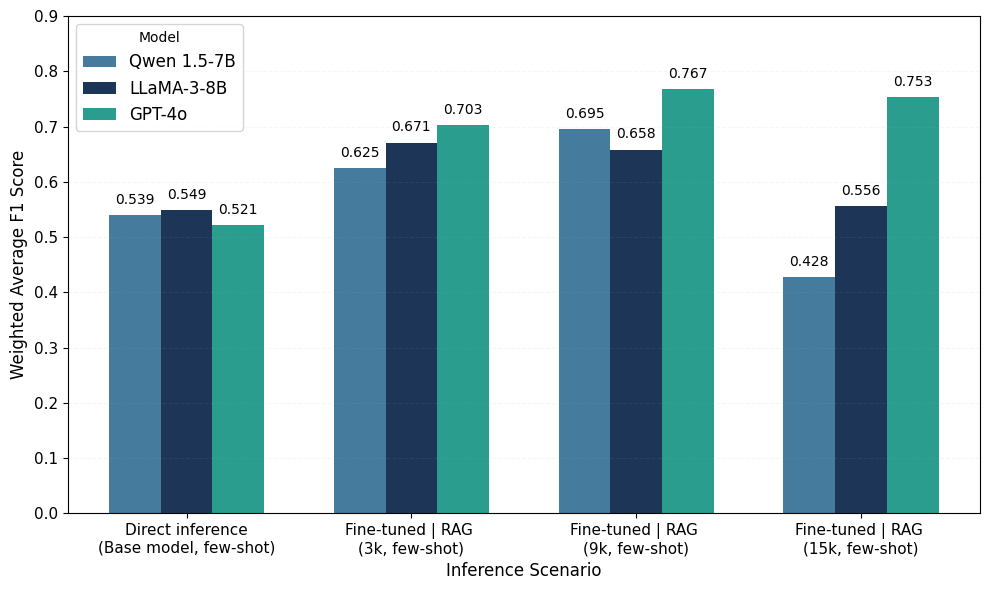

In [18]:
# %matplotlib inline
import matplotlib.pyplot as plt

# Few-shot scenarios only (now 4)
scenarios = [
    "Direct inference\n(Base model, few-shot)",
    "Fine-tuned | RAG \n(3k, few-shot)",   # new scenario
    "Fine-tuned | RAG \n(9k, few-shot)",
    "Fine-tuned | RAG \n(15k, few-shot)"
]

# Corresponding scores
# qwen_scores  = [0.539, 0.541, 0.695, 0.428]
# llama_scores = [0.473, 0.671, 0.658, 0.440]
# gpt4o_scores = [0.521, 0.703, 0.750, 0.746]

qwen_scores  = [0.539, 0.625, 0.695, 0.428]
llama_scores = [0.549, 0.671, 0.658, 0.556]
gpt4o_scores = [0.521, 0.703, 0.767, 0.753]

x = range(len(scenarios))
bar_width = 0.23

# Colors
qwen_color = '#457b9d'
llama_color = '#1d3557'
gpt4o_color = '#2a9d8f'

plt.figure(figsize=(10, 6))

# Bars (three per group)
qwen_bars = plt.bar([i - bar_width for i in x], qwen_scores, width=bar_width, label="Qwen 1.5-7B", color=qwen_color)
llama_bars = plt.bar(x, llama_scores, width=bar_width, label="LLaMA-3-8B", color=llama_color)
gpt4o_bars = plt.bar([i + bar_width for i in x], gpt4o_scores, width=bar_width, label="GPT-4o", color=gpt4o_color)

# # Annotate bars
for bars in [qwen_bars, llama_bars, gpt4o_bars]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.015 if yval >= 0.1 else yval + 0.005,
            f"{yval:.3f}",
            ha='center',
            va='bottom',
            fontsize=10
        )

# Labels and styling
plt.xticks(x, scenarios, rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Inference Scenario", fontsize=12)
plt.ylabel("Weighted Average F1 Score", fontsize=12)
# plt.title("LLM Performance (Few-Shot Scenarios Only)")
plt.ylim(0.0, 0.9)

plt.grid(axis='y', linestyle='--', alpha=0.1)
plt.legend(title="Model", loc='upper left', ncol=1, fontsize=12)
plt.tight_layout()
plt.savefig(r"plots/fine_tuned_LLM_Performance_on_citation_classification.pdf")
plt.show()



## with the new manually verified 1000 samples included

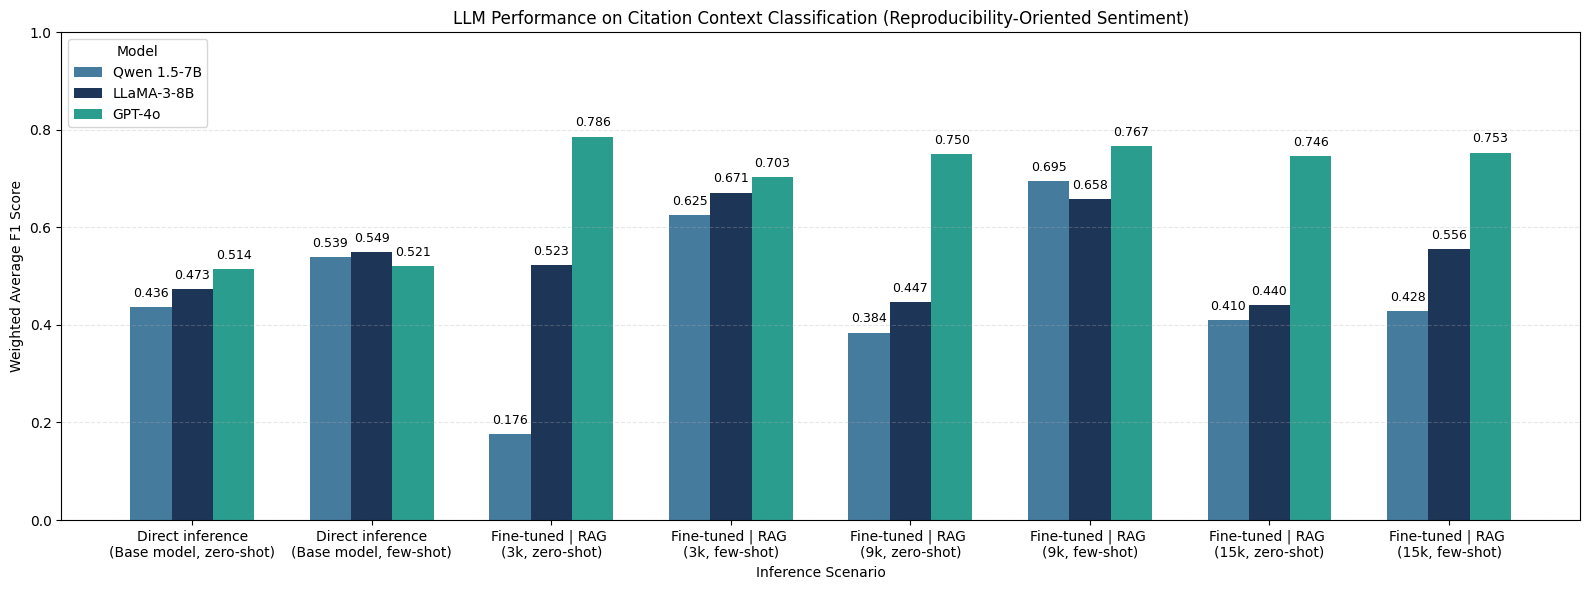

In [4]:
# %matplotlib inline
import matplotlib.pyplot as plt

# Define scenarios (all 8, including Direct inference few-shot)
scenarios = [
    "Direct inference\n(Base model, zero-shot)",
    "Direct inference\n(Base model, few-shot)",
    "Fine-tuned | RAG \n(3k, zero-shot)",
    "Fine-tuned | RAG \n(3k, few-shot)",
    "Fine-tuned | RAG \n(9k, zero-shot)",
    "Fine-tuned | RAG \n(9k, few-shot)",
    "Fine-tuned | RAG \n(15k, zero-shot)",
    "Fine-tuned | RAG \n(15k, few-shot)"
]


qwen_scores  = [0.436, 0.539, 0.176, 0.625, 0.384, 0.695, 0.410, 0.428]
llama_scores = [0.473, 0.549, 0.523, 0.671, 0.447, 0.658, 0.440, 0.556]
gpt4o_scores = [0.514, 0.521, 0.786, 0.703, 0.750, 0.767, 0.746, 0.753]

x = range(len(scenarios))
bar_width = 0.23

# Colors
qwen_color = '#457b9d'
llama_color = '#1d3557'
gpt4o_color = '#2a9d8f'

plt.figure(figsize=(16, 6))

# Bars (three per group)
qwen_bars = plt.bar([i - bar_width for i in x], qwen_scores, width=bar_width, label="Qwen 1.5-7B", color=qwen_color)
llama_bars = plt.bar(x, llama_scores, width=bar_width, label="LLaMA-3-8B", color=llama_color)
gpt4o_bars = plt.bar([i + bar_width for i in x], gpt4o_scores, width=bar_width, label="GPT-4o", color=gpt4o_color)

# Annotate bars
for bars in [qwen_bars, llama_bars, gpt4o_bars]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.015 if yval >= 0.1 else yval + 0.005,
            f"{yval:.3f}",
            ha='center',
            va='bottom',
            fontsize=9
        )

# plt.axhline(y=qwen_scores[0], color=qwen_color, linestyle='--', linewidth=0.8, alpha=0.8)
# plt.axhline(y=llama_scores[0], color=llama_color, linestyle='--', linewidth=0.8, alpha=0.8)

# Labels and styling
plt.xticks(x, scenarios, rotation=0)
plt.xlabel("Inference Scenario")
plt.ylabel("Weighted Average F1 Score")
plt.title("LLM Performance on Citation Context Classification (Reproducibility-Oriented Sentiment)")
plt.ylim(0.0, 1.0)  # expanded to accommodate very low scores

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title="Model", loc='upper left', ncol=1)
plt.tight_layout()
plt.savefig(r"../plots/fine_tuned_LLM_Performance_on_citation_classification.pdf")
plt.show()


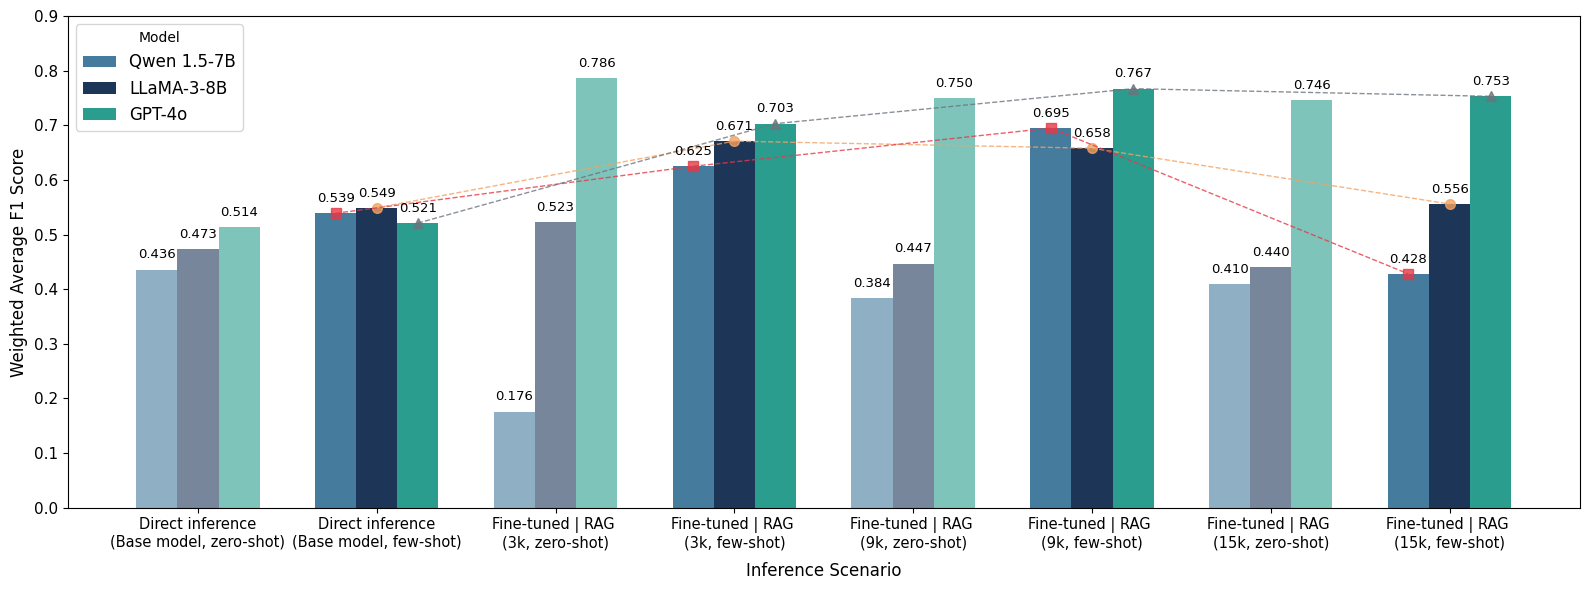

In [57]:
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define scenarios (all 8, including Direct inference few-shot)
scenarios = [
    "Direct inference\n(Base model, zero-shot)",
    "Direct inference\n(Base model, few-shot)",
    "Fine-tuned | RAG \n(3k, zero-shot)",
    "Fine-tuned | RAG \n(3k, few-shot)",
    "Fine-tuned | RAG \n(9k, zero-shot)",
    "Fine-tuned | RAG \n(9k, few-shot)",
    "Fine-tuned | RAG \n(15k, zero-shot)",
    "Fine-tuned | RAG \n(15k, few-shot)"
]

qwen_scores  = [0.436, 0.539, 0.176, 0.625, 0.384, 0.695, 0.410, 0.428]
llama_scores = [0.473, 0.549, 0.523, 0.671, 0.447, 0.658, 0.440, 0.556]
gpt4o_scores = [0.514, 0.521, 0.786, 0.703, 0.750, 0.767, 0.746, 0.753]

x = range(len(scenarios))
bar_width = 0.23

# Colors
qwen_color = '#457b9d'
llama_color = '#1d3557'
gpt4o_color = '#2a9d8f'

plt.figure(figsize=(16, 6))

# Bars (three per group)
qwen_bars = plt.bar([i - bar_width for i in x], qwen_scores, width=bar_width, label="Qwen 1.5-7B", color=qwen_color)
llama_bars = plt.bar(x, llama_scores, width=bar_width, label="LLaMA-3-8B", color=llama_color)
gpt4o_bars = plt.bar([i + bar_width for i in x], gpt4o_scores, width=bar_width, label="GPT-4o", color=gpt4o_color)


# ---- Adjust transparency for zero-shot bars ----
zero_shot_indices = [0, 2, 4, 6]  # indices of zero-shot scenarios

alpha_ = 0.6
for idx in zero_shot_indices:
    qwen_bars[idx].set_alpha(alpha_)   # make zero-shot lighter
    llama_bars[idx].set_alpha(alpha_)
    gpt4o_bars[idx].set_alpha(alpha_)


# Annotate bars
for bars in [qwen_bars, llama_bars, gpt4o_bars]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.015 if yval >= 0.1 else yval + 0.005,
            f"{yval:.3f}",
            ha='center',
            va='bottom',
            fontsize=9.5
        )

# ---- Add trend lines for few-shot only ----
few_shot_indices = [1, 3, 5, 7]  # positions of few-shot scenarios
# few_shot_indices = [0, 2, 4, 6]  # positions of few-shot scenarios

# LLaMA few-shot line
alpha_lines = 0.8
linewidth_ = 1
markersize_ = 7
linestyle_ = "--"

# Highlight colors for line plots
# qwen_line_color = '#a8dadc'
# llama_line_color = '#98c1d9'
# gpt4o_line_color = '#b5e48c'

qwen_line_color = '#e63946'
llama_line_color = '#f4a261'
gpt4o_line_color = '#6c757d'

plt.plot([i for i in few_shot_indices],
         [llama_scores[i] for i in few_shot_indices],
         marker='o', color=llama_line_color, linestyle=linestyle_, linewidth=linewidth_, markersize=markersize_, alpha=alpha_lines, label="_nolegend_")

# Qwen few-shot line
plt.plot([i - bar_width for i in few_shot_indices],
         [qwen_scores[i] for i in few_shot_indices],
         marker='s', color=qwen_line_color, linestyle=linestyle_, linewidth=linewidth_, markersize=markersize_, alpha=alpha_lines, label="_nolegend_")

# # GPT-4o few-shot line
plt.plot([i + bar_width for i in few_shot_indices],
         [gpt4o_scores[i] for i in few_shot_indices],
         marker='^', color=gpt4o_line_color, linestyle=linestyle_, linewidth=linewidth_, markersize=markersize_, alpha=alpha_lines, label="_nolegend_")



zero_shot_indices = [0, 2, 4, 6]  # positions of few-shot scenarios
alpha_lines = 0.5
linewidth_ = 1
markersize_ = 7

# plt.plot([i for i in zero_shot_indices],
#          [llama_scores[i] for i in zero_shot_indices],
#          marker='o', color=llama_line_color, linestyle='--', linewidth=linewidth_, markersize=markersize_, alpha=alpha_lines, label="_nolegend_")

# Qwen few-shot line
# plt.plot([i - bar_width for i in zero_shot_indices],
#          [qwen_scores[i] for i in zero_shot_indices],
#          marker='s', color=qwen_line_color, linestyle='--', linewidth=linewidth_, markersize=markersize_, alpha=alpha_lines, label="_nolegend_")

# # GPT-4o few-shot line
# plt.plot([i + bar_width for i in zero_shot_indices],
#          [gpt4o_scores[i] for i in zero_shot_indices],
#          marker='^', color=gpt4o_line_color, linestyle='--', linewidth=linewidth_, markersize=markersize_, alpha=alpha_lines, label="_nolegend_")


# Labels and styling
plt.xticks(x, scenarios, rotation=0,fontsize=10.5)
plt.yticks(fontsize=11)
plt.xlabel("Inference Scenario", fontsize=12, labelpad=8)
plt.ylabel("Weighted Average F1 Score", fontsize=12)
# plt.title("LLM Performance on Citation Context Classification (Reproducibility-Oriented Sentiment)")
plt.ylim(0.0, 0.9)

legend_handles = [
    Patch(facecolor=qwen_color, label="Qwen 1.5-7B"),
    Patch(facecolor=llama_color, label="LLaMA-3-8B"),
    Patch(facecolor=gpt4o_color, label="GPT-4o")
]

# plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(handles=legend_handles, title="Model", loc='upper left', ncol=1, fontsize=12)
plt.tight_layout()
plt.savefig(r"../plots/fine_tuned_LLM_Performance_on_citation_classification.pdf")
plt.show()


# CC30k: new Dataset creation 

In [15]:
import pandas as pd

# # --- CONFIG ---
# num_instances = 3000
# random_state = 43

# --- LOAD DATA ---
df_cc25k = pd.read_csv(r'cc25k/CC25k_with_metadata_new.csv')
df_neg_verified = pd.read_csv(r'cc25k/extend_cc25k/negative_verfied_1055.csv')
df_neg_all = pd.read_csv(r'cc25k/extend_cc25k/negative_new_binary_predicted_confident_contexts.csv')

df_cc25k['label_type'] = 'crowdsourced'


## cc25k

In [16]:
df_cc25k.columns

Index(['input_index', 'input_context', 'input_file_key', 'input_first_author',
       'worker_id_w1', 'work_time_in_seconds_w1', 'label_w1', 'worker_id_w2',
       'work_time_in_seconds_w2', 'label_w2', 'worker_id_w3',
       'work_time_in_seconds_w3', 'label_w3', 'batch', 'majority_vote',
       'majority_agreement', 'rs_doi', 'rs_title', 'rs_authors', 'rs_year',
       'rs_venue', 'rs_selected_claims', 'rs_reproduced_claims', 'rs_score',
       's2ga_key', 'reproducibility', 'rs_key', 'org_doi', 'org_title',
       'org_authors', 'org_year', 'org_venue', 'org_paper_url',
       'org_citations', 'rs_key_', 'text', 'citing_doi', 'citing_year',
       'citing_venue', 'citing_title', 'citing_authors', 'label_type'],
      dtype='object')

In [17]:
list(df_cc25k.columns)

['input_index',
 'input_context',
 'input_file_key',
 'input_first_author',
 'worker_id_w1',
 'work_time_in_seconds_w1',
 'label_w1',
 'worker_id_w2',
 'work_time_in_seconds_w2',
 'label_w2',
 'worker_id_w3',
 'work_time_in_seconds_w3',
 'label_w3',
 'batch',
 'majority_vote',
 'majority_agreement',
 'rs_doi',
 'rs_title',
 'rs_authors',
 'rs_year',
 'rs_venue',
 'rs_selected_claims',
 'rs_reproduced_claims',
 'rs_score',
 's2ga_key',
 'reproducibility',
 'rs_key',
 'org_doi',
 'org_title',
 'org_authors',
 'org_year',
 'org_venue',
 'org_paper_url',
 'org_citations',
 'rs_key_',
 'text',
 'citing_doi',
 'citing_year',
 'citing_venue',
 'citing_title',
 'citing_authors',
 'label_type']

In [18]:
df_cc25k = df_cc25k[
            ['input_index',
             'input_context',
             'input_file_key',
             'input_first_author',
             'worker_id_w1',
             'work_time_in_seconds_w1',
             'label_w1',
             'worker_id_w2',
             'work_time_in_seconds_w2',
             'label_w2',
             'worker_id_w3',
             'work_time_in_seconds_w3',
             'label_w3',
             'batch',
             'majority_vote',
             'majority_agreement',
             'rs_doi',
             'rs_title',
             'rs_authors',
             'rs_year',
             'rs_venue',
             'rs_selected_claims',
             'rs_reproduced_claims',
             'rs_score',#
             's2ga_key',#
             'reproducibility',
             'rs_key',#
             'org_doi',
             'org_title',
             'org_authors',
             'org_year',
             'org_venue',
             'org_paper_url',
             'org_citations',
             'citing_doi',
             'citing_year',
             'citing_venue',
             'citing_title',
             'citing_authors',
             'label_type']
]

In [19]:
df_cc25k.head(3)

,input_index,input_context,input_file_key,input_first_author,worker_id_w1,work_time_in_seconds_w1,label_w1,worker_id_w2,work_time_in_seconds_w2,label_w2,...,org_year,org_venue,org_paper_url,org_citations,citing_doi,citing_year,citing_venue,citing_title,citing_authors,label_type
0,0,"Instead of mixing the representations, G-Mixup...",RS_001_MLRC_2022_01,First Author: Han,A5V3ZMQI0PU3F,28,Neutral,A18LFH7XW61JO9,15,Neutral,...,2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76,10.48550/arXiv.2309.10979,2023.0,arXiv.org,Towards Data-centric Graph Machine Learning: R...,"['Xin Zheng', 'Yixin Liu', 'Zhifeng Bao', 'Men...",crowdsourced
1,3,"For G-Mixup, we use the same hyper-parameters ...",RS_001_MLRC_2022_01,First Author: Han,A18LFH7XW61JO9,55,Positive,AKSJ3C5O3V9RB,49570,Positive,...,2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76,10.1007/978-3-031-43418-1_19,2023.0,NaN,GDM: Dual Mixup for Graph Classification with ...,"['Abdullah Alchihabi', 'Yuhong Guo']",crowdsourced
2,6,G-Mixup performs mixup to the graphons of diff...,RS_001_MLRC_2022_01,First Author: Han,A18LFH7XW61JO9,155,Neutral,A2R2YZTSME1K3F,50,Neutral,...,2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76,10.1007/978-3-031-43418-1_19,2023.0,NaN,GDM: Dual Mixup for Graph Classification with ...,"['Abdullah Alchihabi', 'Yuhong Guo']",crowdsourced


## augmented human validated AHV

In [30]:
list(df_neg_verified.columns)

['cited_paper_id',
 'context',
 'isInfluential',
 'citing_paperId',
 'citing_paper_title',
 'citing_paper_year',
 'citing_paper_publicationVenue',
 'citing_paper_author_names',
 'pred_biobert_model',
 'confidence_biobert_model',
 'pred_distibert_model',
 'confidence_distibert_model',
 'pred_repro_model',
 'confidence_repro_model',
 'pred_bluebert_model',
 'confidence_bluebert_model',
 'pred_specter_model',
 'confidence_specter_model',
 'majority_vote',
 'actually_negative',
 'row highlight',
 'All negatives: 1055',
 'label_type']

In [24]:
df_neg_verified = df_neg_verified[df_neg_verified["actually_negative"]==True]

In [26]:
df_neg_verified['label_type'] = 'augmented_human_validated'

In [32]:
df_neg_verified['majority_vote'] = "Negative"

In [34]:
df_neg_verified.head(3)

,cited_paper_id,context,isInfluential,citing_paperId,citing_paper_title,citing_paper_year,citing_paper_publicationVenue,citing_paper_author_names,pred_biobert_model,confidence_biobert_model,pred_distibert_model,confidence_distibert_model,pred_repro_model,confidence_repro_model,pred_bluebert_model,confidence_bluebert_model,pred_specter_model,confidence_specter_model,majority_vote,label_type
2,5826d8f3fb3ccd79cfaf292bb0ddc5eebc13a580,"However, textual entailment could have been co...",True,236375f49e3deb8ee7918c1f5e65175e453deb2e,Rethinking the Event Coding Pipeline with Prom...,2022.0,NaN,"C. Lefebvre, Niklas Stoehr",0,0.992921,0,0.503219,0,0.988721,0,0.987777,0,0.755429,Negative,augmented_human_validated
3,73ec11e398f52d29f6866c58e5ba0bd935264e95,"Alternatively, penetrance estimates for most g...",False,507be7a1c111df5ca04038fa7342e47f6dc0d070,Reduced Penetrance is Common Among Predicted L...,2024.0,medRxiv,"D. R. Blair, N. Risch",0,0.990263,0,0.989640,0,0.993473,0,0.986165,0,0.996029,Negative,augmented_human_validated
6,73ec11e398f52d29f6866c58e5ba0bd935264e95,They also don’t make a concession of variant c...,False,9c1e3ca9f57f374cc7bd15681c6367e1fbdd75d9,COSAP: Comparative Sequencing Analysis Platform,2024.0,BMC Bioinformatics,"Mehmet Arif Ergun, Omer Cinal, Berkant Bakışlı...",0,0.995719,0,0.994535,0,0.985427,0,0.993662,0,0.996603,Negative,augmented_human_validated


In [37]:
df_neg_verified = df_neg_verified[
    ['cited_paper_id',
     'context',
     'citing_paperId',
     'citing_paper_title',
     'citing_paper_year',
     'citing_paper_publicationVenue',
     'citing_paper_author_names',
     'majority_vote',
     'label_type'
    ]
]

In [41]:
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_columns')
df_neg_verified.head(5)

df_neg_verified = df_neg_verified.rename(columns={'context': 'input_context',
                                                  'citing_paper_title': 'citing_title',
                                                  'citing_paper_year': 'citing_year',
                                                  'citing_paper_publicationVenue': 'citing_venue',
                                                  'citing_paper_author_names': 'citing_authors'})
df_neg_verified

,cited_paper_id,input_context,citing_paperId,citing_title,citing_year,citing_venue,citing_authors,majority_vote,label_type
2,5826d8f3fb3ccd79cfaf292bb0ddc5eebc13a580,"However, textual entailment could have been co...",236375f49e3deb8ee7918c1f5e65175e453deb2e,Rethinking the Event Coding Pipeline with Prom...,2022.0,NaN,"C. Lefebvre, Niklas Stoehr",Negative,augmented_human_validated
3,73ec11e398f52d29f6866c58e5ba0bd935264e95,"Alternatively, penetrance estimates for most g...",507be7a1c111df5ca04038fa7342e47f6dc0d070,Reduced Penetrance is Common Among Predicted L...,2024.0,medRxiv,"D. R. Blair, N. Risch",Negative,augmented_human_validated
6,73ec11e398f52d29f6866c58e5ba0bd935264e95,They also don’t make a concession of variant c...,9c1e3ca9f57f374cc7bd15681c6367e1fbdd75d9,COSAP: Comparative Sequencing Analysis Platform,2024.0,BMC Bioinformatics,"Mehmet Arif Ergun, Omer Cinal, Berkant Bakışlı...",Negative,augmented_human_validated
7,73ec11e398f52d29f6866c58e5ba0bd935264e95,…missing best practice recommendations—most im...,7d484024126c8711896895d10dd1eab2cd6cc337,Validated WGS and WES protocols proved saliva-...,2024.0,BMC Genomics,"K. Kvapilová, Pavol Mišenko, J. Radvánszky, On...",Negative,augmented_human_validated
9,73ec11e398f52d29f6866c58e5ba0bd935264e95,…urgently demand rigorous cataloging and asses...,966b5bbd54f4b2da7bbd52455ab9ac6e5f29f851,Comprehensive benchmarking and guidelines of m...,2023.0,Nature Methods,"Yoo-Jin Ha, Seungseok Kang, Jisoo Kim, Jun-Hyu...",Negative,augmented_human_validated
...,...,...,...,...,...,...,...,...,...
7470,66a6782dad331cb37bca2b190c9978e120fba317,"However, existing computational approaches are...",0c7ff554c98435b398c0f8687c8bd6e7dbbfbf0d,Elaborative Simplification: Content Addition a...,2020.0,Findings,"Neha Srikanth, Junyi Jessy Li",Negative,augmented_human_validated
7492,05049e1e60157d7f1f6aba4e11a304b61acef110,"(4) (cf. [16, 17]), but these studies are outs...",b5dbd573da6721000db862755d3d290ec1a68637,Shadow hamiltonian simulation,2024.0,Nature Communications,"Rolando D Somma, Robbie King, Robin Kothari, T...",Negative,augmented_human_validated
7504,489f76879f3795c029d28639580416bba43ff424,"However, other than recent work limited to the...",98ddb3f11832a7d5803f3da84365f1fec49c3230,A Unified and Practical Approach for Generaliz...,2024.0,arXiv.org,"Neha Makhija, Wolfgang Gatterbauer",Negative,augmented_human_validated
7527,a4bdc42392ad00ed5ce7803982eadd44b99dea1b,"However, these methods struggle with generaliz...",8e5cff2b6fc747f3fe682c4a76469e8517957c7c,Negative-Sample-Free Contrastive Self-Supervis...,2024.0,IEEE Access,"In-Nea Wang, Cheol-Hui Lee, Hakseung Kim, Dong...",Negative,augmented_human_validated


In [44]:
import os
import json
import pandas as pd

# Function to extract details of the matching citingPaper
def extract_matching_details(cited_paper_id, citing_paper_id):
    json_file = f"cc25k/extend_cc25k/all_citation_contexts/{cited_paper_id}.json"
    try:
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        # Loop through all items inside the JSON file
        for item in data:
            citing = item.get("citingPaper", {})
            if citing.get("paperId") == citing_paper_id:
                # Return the fields you want
                return pd.Series([
                    citing.get("externalIds", {}).get("DOI")
                ])

        return pd.Series([None])

    except Exception as e:
        print(f"Error reading {json_file}: {e}")
        return pd.Series([None])


df_neg_verified[["citing_doi"]] = df_neg_verified.apply(
    lambda row: extract_matching_details(row["cited_paper_id"], row["citing_paperId"]),
    axis=1
)


In [46]:
df_neg_verified.columns.to_list()

['cited_paper_id',
 'input_context',
 'citing_paperId',
 'citing_title',
 'citing_year',
 'citing_venue',
 'citing_authors',
 'majority_vote',
 'label_type',
 'citing_doi']

In [49]:
df_neg_verified = df_neg_verified[['cited_paper_id',
         'input_context',
         'citing_paperId',
         'citing_doi',
         'citing_year',
         'citing_venue',
         'citing_title',
         'citing_authors',
         'majority_vote',
         'label_type'
         ]]

df_neg_verified

,cited_paper_id,input_context,citing_paperId,citing_doi,citing_year,citing_venue,citing_title,citing_authors,majority_vote,label_type
2,5826d8f3fb3ccd79cfaf292bb0ddc5eebc13a580,"However, textual entailment could have been co...",236375f49e3deb8ee7918c1f5e65175e453deb2e,10.48550/arXiv.2210.05257,2022.0,NaN,Rethinking the Event Coding Pipeline with Prom...,"C. Lefebvre, Niklas Stoehr",Negative,augmented_human_validated
3,73ec11e398f52d29f6866c58e5ba0bd935264e95,"Alternatively, penetrance estimates for most g...",507be7a1c111df5ca04038fa7342e47f6dc0d070,10.1101/2024.09.23.24314008,2024.0,medRxiv,Reduced Penetrance is Common Among Predicted L...,"D. R. Blair, N. Risch",Negative,augmented_human_validated
6,73ec11e398f52d29f6866c58e5ba0bd935264e95,They also don’t make a concession of variant c...,9c1e3ca9f57f374cc7bd15681c6367e1fbdd75d9,10.1186/s12859-024-05756-z,2024.0,BMC Bioinformatics,COSAP: Comparative Sequencing Analysis Platform,"Mehmet Arif Ergun, Omer Cinal, Berkant Bakışlı...",Negative,augmented_human_validated
7,73ec11e398f52d29f6866c58e5ba0bd935264e95,…missing best practice recommendations—most im...,7d484024126c8711896895d10dd1eab2cd6cc337,10.1186/s12864-024-10080-0,2024.0,BMC Genomics,Validated WGS and WES protocols proved saliva-...,"K. Kvapilová, Pavol Mišenko, J. Radvánszky, On...",Negative,augmented_human_validated
9,73ec11e398f52d29f6866c58e5ba0bd935264e95,…urgently demand rigorous cataloging and asses...,966b5bbd54f4b2da7bbd52455ab9ac6e5f29f851,10.1038/s41592-023-02043-2,2023.0,Nature Methods,Comprehensive benchmarking and guidelines of m...,"Yoo-Jin Ha, Seungseok Kang, Jisoo Kim, Jun-Hyu...",Negative,augmented_human_validated
...,...,...,...,...,...,...,...,...,...,...
7470,66a6782dad331cb37bca2b190c9978e120fba317,"However, existing computational approaches are...",0c7ff554c98435b398c0f8687c8bd6e7dbbfbf0d,10.18653/v1/2021.findings-acl.455,2020.0,Findings,Elaborative Simplification: Content Addition a...,"Neha Srikanth, Junyi Jessy Li",Negative,augmented_human_validated
7492,05049e1e60157d7f1f6aba4e11a304b61acef110,"(4) (cf. [16, 17]), but these studies are outs...",b5dbd573da6721000db862755d3d290ec1a68637,10.1038/s41467-025-57451-z,2024.0,Nature Communications,Shadow hamiltonian simulation,"Rolando D Somma, Robbie King, Robin Kothari, T...",Negative,augmented_human_validated
7504,489f76879f3795c029d28639580416bba43ff424,"However, other than recent work limited to the...",98ddb3f11832a7d5803f3da84365f1fec49c3230,10.48550/arXiv.2411.17603,2024.0,arXiv.org,A Unified and Practical Approach for Generaliz...,"Neha Makhija, Wolfgang Gatterbauer",Negative,augmented_human_validated
7527,a4bdc42392ad00ed5ce7803982eadd44b99dea1b,"However, these methods struggle with generaliz...",8e5cff2b6fc747f3fe682c4a76469e8517957c7c,10.1109/ACCESS.2024.3459866,2024.0,IEEE Access,Negative-Sample-Free Contrastive Self-Supervis...,"In-Nea Wang, Cheol-Hui Lee, Hakseung Kim, Dong...",Negative,augmented_human_validated


In [54]:
import json 
with open(r'cc25k/extend_cc25k/cs_paper_details.json', 'r',encoding = 'utf-8') as f:
        cs_paper_all_dict = json.loads(f.read())


In [53]:
cs_paper_all_dict[2]

{'paperId': '0df56443240c19fb83c81520e5ebead86e9ceaa1',
 'externalIds': {'DBLP': 'journals/algorithms/YangGJT22',
  'DOI': '10.3390/a15050146',
  'CorpusId': 249172903},
 'corpusId': 249172903,
 'title': 'Large-Scale Multimodal Piano Music Identification Using Marketplace Fingerprinting',
 'year': 2022,
 'referenceCount': 46,
 'citationCount': 6,
 'openAccessPdf': {'url': 'https://www.mdpi.com/1999-4893/15/5/146/pdf?version=1650965652',
  'status': 'GOLD'},
 'fieldsOfStudy': ['Computer Science'],
 's2FieldsOfStudy': [{'category': 'Computer Science', 'source': 'external'},
  {'category': 'Computer Science', 'source': 's2-fos-model'}]}

In [60]:
import pandas as pd

cited_paper_dict_ = {p["paperId"]: p for p in cs_paper_all_dict}

def extract_cited_details(cited_paper_id):
    cited = cited_paper_dict_.get(cited_paper_id, {})
    if not cited:
        return pd.Series([None, None, None, None])

    open_access = cited.get("openAccessPdf") if isinstance(cited.get("openAccessPdf"), dict) else {}
    
        
    return pd.Series([
        cited.get("externalIds", {}).get("DOI",{}),
        cited.get("title"),
        cited.get("year"),
        open_access.get("url")
    ])

df_neg_verified[["org_doi", "org_title", "org_year", "org_paper_url"]] = df_neg_verified["cited_paper_id"].apply(extract_cited_details)

df_neg_verified.to_csv(r"cc25k/extend_cc25k/augmented_human_validated_negatives_.csv", index=False)
df_neg_verified

/tmp/ipykernel_279566/2885913592.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg_verified[["org_doi", "org_title", "org_year", "org_paper_url"]] = df_neg_verified["cited_paper_id"].apply(extract_cited_details)
/tmp/ipykernel_279566/2885913592.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg_verified[["org_doi", "org_title", "org_year", "org_paper_url"]] = df_neg_verified["cited_paper_id"].apply(extract_cited_details)
/tmp/ipykernel_279566/2885913592.py:31: SettingWithCopyWarning: 
A v

,cited_paper_id,input_context,citing_paperId,citing_doi,citing_year,citing_venue,citing_title,citing_authors,majority_vote,label_type,org_doi,org_title,org_year,org_paper_url
2,5826d8f3fb3ccd79cfaf292bb0ddc5eebc13a580,"However, textual entailment could have been co...",236375f49e3deb8ee7918c1f5e65175e453deb2e,10.48550/arXiv.2210.05257,2022.0,NaN,Rethinking the Event Coding Pipeline with Prom...,"C. Lefebvre, Niklas Stoehr",Negative,augmented_human_validated,10.18653/v1/2021.case-1.24,IBM MNLP IE at CASE 2021 Task 2: NLI Reranking...,2021,https://aclanthology.org/2021.case-1.24.pdf
3,73ec11e398f52d29f6866c58e5ba0bd935264e95,"Alternatively, penetrance estimates for most g...",507be7a1c111df5ca04038fa7342e47f6dc0d070,10.1101/2024.09.23.24314008,2024.0,medRxiv,Reduced Penetrance is Common Among Predicted L...,"D. R. Blair, N. Risch",Negative,augmented_human_validated,10.1038/s41598-020-77218-4,Accuracy and efficiency of germline variant ca...,2020,https://www.nature.com/articles/s41598-020-772...
6,73ec11e398f52d29f6866c58e5ba0bd935264e95,They also don’t make a concession of variant c...,9c1e3ca9f57f374cc7bd15681c6367e1fbdd75d9,10.1186/s12859-024-05756-z,2024.0,BMC Bioinformatics,COSAP: Comparative Sequencing Analysis Platform,"Mehmet Arif Ergun, Omer Cinal, Berkant Bakışlı...",Negative,augmented_human_validated,10.1038/s41598-020-77218-4,Accuracy and efficiency of germline variant ca...,2020,https://www.nature.com/articles/s41598-020-772...
7,73ec11e398f52d29f6866c58e5ba0bd935264e95,…missing best practice recommendations—most im...,7d484024126c8711896895d10dd1eab2cd6cc337,10.1186/s12864-024-10080-0,2024.0,BMC Genomics,Validated WGS and WES protocols proved saliva-...,"K. Kvapilová, Pavol Mišenko, J. Radvánszky, On...",Negative,augmented_human_validated,10.1038/s41598-020-77218-4,Accuracy and efficiency of germline variant ca...,2020,https://www.nature.com/articles/s41598-020-772...
9,73ec11e398f52d29f6866c58e5ba0bd935264e95,…urgently demand rigorous cataloging and asses...,966b5bbd54f4b2da7bbd52455ab9ac6e5f29f851,10.1038/s41592-023-02043-2,2023.0,Nature Methods,Comprehensive benchmarking and guidelines of m...,"Yoo-Jin Ha, Seungseok Kang, Jisoo Kim, Jun-Hyu...",Negative,augmented_human_validated,10.1038/s41598-020-77218-4,Accuracy and efficiency of germline variant ca...,2020,https://www.nature.com/articles/s41598-020-772...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7470,66a6782dad331cb37bca2b190c9978e120fba317,"However, existing computational approaches are...",0c7ff554c98435b398c0f8687c8bd6e7dbbfbf0d,10.18653/v1/2021.findings-acl.455,2020.0,Findings,Elaborative Simplification: Content Addition a...,"Neha Srikanth, Junyi Jessy Li",Negative,augmented_human_validated,10.18653/v1/N19-1089,PoMo: Generating Entity-Specific Post-Modifier...,2019,None
7492,05049e1e60157d7f1f6aba4e11a304b61acef110,"(4) (cf. [16, 17]), but these studies are outs...",b5dbd573da6721000db862755d3d290ec1a68637,10.1038/s41467-025-57451-z,2024.0,Nature Communications,Shadow hamiltonian simulation,"Rolando D Somma, Robbie King, Robin Kothari, T...",Negative,augmented_human_validated,10.22331/q-2021-11-10-574,High-precision quantum algorithms for partial ...,2020,https://quantum-journal.org/papers/q-2021-11-1...
7504,489f76879f3795c029d28639580416bba43ff424,"However, other than recent work limited to the...",98ddb3f11832a7d5803f3da84365f1fec49c3230,10.48550/arXiv.2411.17603,2024.0,arXiv.org,A Unified and Practical Approach for Generaliz...,"Neha Makhija, Wolfgang Gatterbauer",Negative,augmented_human_validated,10.1145/3626715,A Unified Approach for Resilience and Causal R...,2022,https://dl.acm.org/doi/pdf/10.1145/3626715
7527,a4bdc42392ad00ed5ce7803982eadd44b99dea1b,"However, these methods struggle with generaliz...",8e5cff2b6fc747f3fe682c4a76469e8517957c7c,10.1109/ACCESS.2024.3459866,2024.0,IEEE Access,Negative-Sample-Free Contrastive Self-Supervis...,"In-Nea Wang, Cheol-Hui Lee, Hakseung Kim, Dong...",Negative,augmented_human_validated,10.33

In [67]:
df_neg_verified = df_neg_verified.rename(columns={'cited_paper_id': 'org_s2ga_id'})

In [68]:
df_cc25k = df_cc25k.rename(columns={'s2ga_key': 'org_s2ga_id'})

In [69]:
df_combined_1 = pd.concat(
    [df_cc25k, df_neg_verified],
    ignore_index=True,
    sort=False
)

df_combined_1

,input_index,input_context,input_file_key,input_first_author,worker_id_w1,work_time_in_seconds_w1,label_w1,worker_id_w2,work_time_in_seconds_w2,label_w2,worker_id_w3,work_time_in_seconds_w3,label_w3,batch,majority_vote,majority_agreement,rs_doi,rs_title,rs_authors,rs_year,rs_venue,rs_selected_claims,rs_reproduced_claims,rs_score,org_s2ga_id,reproducibility,rs_key,org_doi,org_title,org_authors,org_year,org_venue,org_paper_url,org_citations,citing_doi,citing_year,citing_venue,citing_title,citing_authors,label_type,citing_paperId
0,0.0,"Instead of mixing the representations, G-Mixup...",RS_001_MLRC_2022_01,First Author: Han,A5V3ZMQI0PU3F,28.0,Neutral,A18LFH7XW61JO9,15.0,Neutral,A2R2YZTSME1K3F,35.0,Neutral,batch_1,Neutral,3.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.48550/arXiv.2309.10979,2023.0,arXiv.org,Towards Data-centric Graph Machine Learning: R...,"['Xin Zheng', 'Yixin Liu', 'Zhifeng Bao', 'Men...",crowdsourced,NaN
1,3.0,"For G-Mixup, we use the same hyper-parameters ...",RS_001_MLRC_2022_01,First Author: Han,A18LFH7XW61JO9,55.0,Positive,AKSJ3C5O3V9RB,49570.0,Positive,A2R2YZTSME1K3F,40.0,Positive,batch_1,Positive,3.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.1007/978-3-031-43418-1_19,2023.0,NaN,GDM: Dual Mixup for Graph Classification with ...,"['Abdullah Alchihabi', 'Yuhong Guo']",crowdsourced,NaN
2,6.0,G-Mixup performs mixup to the graphons of diff...,RS_001_MLRC_2022_01,First Author: Han,A18LFH7XW61JO9,155.0,Neutral,A2R2YZTSME1K3F,50.0,Neutral,A1NF6PELRKACS9,89.0,Positive,batch_1,Neutral,2.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.1007/978-3-031-43418-1_19,2023.0,NaN,GDM: Dual Mixup for Graph Classification with ...,"['Abdullah Alchihabi', 'Yuhong Guo']",crowdsourced,NaN
3,8.0,Our result generalizes that of [16] by allowin...,RS_001_MLRC_2022_01,First Author: Han,A5V3ZMQI0PU3F,17.0,Positive,A18LFH7XW61JO9,13.0,Neutral,A2R2YZTSME1K3F,53.0,Positive,batch_1,Positive,2.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.48550/arXiv.2309.07453,2023.0,arXiv.org,SC-MAD: Mixtures of Higher-order Networks for ...,"['Madeline Navarro', 'Santiago Segarra']",crowdsourced,NaN
4,9.0,"Note that for complexons of dimension 1, when ...",RS_001_MLRC_2022_01,First Author: Han,A5V3ZMQI0PU3F,84.0,Neutral,A18LFH7XW61JO9,144.0,Neutral,A2R2YZTSME1K3F,52.0,Neutral,batch_1,Neutral,3.0,htt

In [70]:
df_combined_1 = df_combined_1.rename(columns={'citing_paperId': 'citing_s2ga_id'})

In [73]:
df_combined_1.columns.to_list()

['input_index',
 'input_context',
 'input_file_key',
 'input_first_author',
 'worker_id_w1',
 'work_time_in_seconds_w1',
 'label_w1',
 'worker_id_w2',
 'work_time_in_seconds_w2',
 'label_w2',
 'worker_id_w3',
 'work_time_in_seconds_w3',
 'label_w3',
 'batch',
 'majority_vote',
 'majority_agreement',
 'rs_doi',
 'rs_title',
 'rs_authors',
 'rs_year',
 'rs_venue',
 'rs_selected_claims',
 'rs_reproduced_claims',
 'rs_score',
 'org_s2ga_id',
 'reproducibility',
 'rs_key',
 'org_doi',
 'org_title',
 'org_authors',
 'org_year',
 'org_venue',
 'org_paper_url',
 'org_citations',
 'citing_doi',
 'citing_year',
 'citing_venue',
 'citing_title',
 'citing_authors',
 'label_type',
 'citing_s2ga_id']

In [74]:
df_combined_1 = df_combined_1[['input_index',
 'input_context',
 'input_file_key',
 'input_first_author',
 'worker_id_w1',
 'work_time_in_seconds_w1',
 'label_w1',
 'worker_id_w2',
 'work_time_in_seconds_w2',
 'label_w2',
 'worker_id_w3',
 'work_time_in_seconds_w3',
 'label_w3',
 'batch',
 'majority_vote',
 'majority_agreement',
 'rs_doi',
 'rs_title',
 'rs_authors',
 'rs_year',
 'rs_venue',
 'rs_selected_claims',
 'rs_reproduced_claims',
 'rs_score',
 'org_s2ga_id',
 'reproducibility',
 'rs_key',
 'org_doi',
 'org_title',
 'org_authors',
 'org_year',
 'org_venue',
 'org_paper_url',
 'org_citations',
 'citing_doi',
 'citing_year',
 'citing_venue',
 'citing_title',
 'citing_authors',
 'citing_s2ga_id',
 'label_type'
]
]

## augmented machine labelled AML

In [87]:
df_neg_all = pd.read_csv(r'cc25k/extend_cc25k/negative_new_binary_predicted_confident_contexts.csv')

df_neg_all = df_neg_all.sample(
    n=3850,
    random_state=43
)

In [88]:
list(df_neg_all.columns)

['cited_paper_id',
 'context',
 'isInfluential',
 'citing_paperId',
 'citing_paper_title',
 'citing_paper_year',
 'citing_paper_publicationVenue',
 'citing_paper_author_names',
 'pred_biobert_model',
 'confidence_biobert_model',
 'pred_distibert_model',
 'confidence_distibert_model',
 'pred_repro_model',
 'confidence_repro_model',
 'pred_bluebert_model',
 'confidence_bluebert_model',
 'pred_specter_model',
 'confidence_specter_model',
 'majority_vote',
 'actually_negative',
 'row highlight',
 'All negatives: 1055',
 'predicted_label',
 'confidence']

In [89]:
df_neg_all['label_type'] = 'augmented_machine_labelled'

In [90]:
df_neg_all['majority_vote'] = "Negative"

In [91]:
df_neg_all = df_neg_all[
    ['cited_paper_id',
     'context',
     'isInfluential',
     'citing_paperId',
     'citing_paper_title',
     'citing_paper_year',
     'citing_paper_publicationVenue',
     'citing_paper_author_names',
     'pred_biobert_model',
     'confidence_biobert_model',
     'pred_distibert_model',
     'confidence_distibert_model',
     'pred_repro_model',
     'confidence_repro_model',
     'pred_bluebert_model',
     'confidence_bluebert_model',
     'pred_specter_model',
     'confidence_specter_model',
     'majority_vote',
     'predicted_label',
     'confidence',
     'label_type'
    ]
]

df_neg_all.to_csv(r'cc25k/extend_cc25k/augmented_machine_labelled_negatives.csv',index=False)

In [92]:
df_neg_all.head(3)

,cited_paper_id,context,isInfluential,citing_paperId,citing_paper_title,citing_paper_year,citing_paper_publicationVenue,citing_paper_author_names,pred_biobert_model,confidence_biobert_model,pred_distibert_model,confidence_distibert_model,pred_repro_model,confidence_repro_model,pred_bluebert_model,confidence_bluebert_model,pred_specter_model,confidence_specter_model,majority_vote,predicted_label,confidence,label_type
10301,e140ec8c22bf4e524d18aac1b7e522620c1d32d9,While datasets like the TED-Gesture dataset (Y...,False,5d81f4f039838adc5bbdb6fbbe324b46c19993a5,Large Body Language Models,2024.0,arXiv.org,"Saif Punjwani, Larry Heck",0,0.994801,0,0.994772,0,0.996928,0,0.993732,0,0.997904,Negative,0,0.998572,augmented_machine_labelled
11544,932e72e7fc79d8878dc4d36ae217393ac6723282,"Furthermore, existing studies that utilize pac...",False,576caa94733d3f7fb86070628b0d0a9c38d572f4,Intrusion Detection for Encrypted Flows Using ...,2024.0,IEEE Internet of Things Journal,"Ying Han, Xinlei Wang, Mingshu He, Xiaojuan Wa...",0,0.974786,1,0.894304,0,0.984377,0,0.982680,0,0.514788,Negative,0,0.997900,augmented_machine_labelled
5297,0b5f443d9fae1d5cb90994025e0ce21ddc49c21c,This may not be a valid assumption given the e...,False,9afa4b6d886739a4386084f647be90e67adde28d,Secure Shapley Value for Cross-Silo Federated ...,2022.0,Proceedings of the VLDB Endowment,"Shuyuan Zheng, Yang Cao, Masatoshi Yoshikawa",0,0.994261,0,0.994338,0,0.996274,0,0.993780,0,0.998771,Negative,0,0.996304,augmented_machine_labelled


In [93]:
df_neg_all = df_neg_all[
    ['cited_paper_id',
     'context',
     'citing_paperId',
     'citing_paper_title',
     'citing_paper_year',
     'citing_paper_publicationVenue',
     'citing_paper_author_names',
     'majority_vote',
     'label_type'
    ]
]

In [94]:
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_columns')
df_neg_all.head(5)

df_neg_all = df_neg_all.rename(columns={'context': 'input_context',
                                          'citing_paper_title': 'citing_title',
                                          'citing_paper_year': 'citing_year',
                                          'citing_paper_publicationVenue': 'citing_venue',
                                          'citing_paper_author_names': 'citing_authors'})
df_neg_all

,cited_paper_id,input_context,citing_paperId,citing_title,citing_year,citing_venue,citing_authors,majority_vote,label_type
10301,e140ec8c22bf4e524d18aac1b7e522620c1d32d9,While datasets like the TED-Gesture dataset (Y...,5d81f4f039838adc5bbdb6fbbe324b46c19993a5,Large Body Language Models,2024.0,arXiv.org,"Saif Punjwani, Larry Heck",Negative,augmented_machine_labelled
11544,932e72e7fc79d8878dc4d36ae217393ac6723282,"Furthermore, existing studies that utilize pac...",576caa94733d3f7fb86070628b0d0a9c38d572f4,Intrusion Detection for Encrypted Flows Using ...,2024.0,IEEE Internet of Things Journal,"Ying Han, Xinlei Wang, Mingshu He, Xiaojuan Wa...",Negative,augmented_machine_labelled
5297,0b5f443d9fae1d5cb90994025e0ce21ddc49c21c,This may not be a valid assumption given the e...,9afa4b6d886739a4386084f647be90e67adde28d,Secure Shapley Value for Cross-Silo Federated ...,2022.0,Proceedings of the VLDB Endowment,"Shuyuan Zheng, Yang Cao, Masatoshi Yoshikawa",Negative,augmented_machine_labelled
3,a10c1721da60b899dcc09fbcf2d751485f1ae29d,"Agile Testing [6,7,10,11,12,16,18,19,20,21,22,...",bffcd229dffeb26ced80d333d753593c2eb9502a,The Integrated List of Agile Practices - A Ter...,2021.0,International Conference on Lean and Agile Sof...,M. Neumann,Negative,augmented_machine_labelled
11631,909fd2beaa5cd7ef13e36209d1a320f8af470cee,"Finally, even for textual evidence, most previ...",80982f69a7581e31f61c719586a71ee576213006,TabVer: Tabular Fact Verification with Natural...,2024.0,Transactions of the Association for Computatio...,"Rami Aly, Andreas Vlachos",Negative,augmented_machine_labelled
...,...,...,...,...,...,...,...,...,...
3979,b0478b3862e908748500f8f836dadabe1ca3f0b1,Both Long Path and Long Cycle are unlikely to ...,0a689a2df953b7419a784fbb49d88484117794bd,ETH-Tight Algorithms for Long Path and Cycle o...,2020.0,International Symposium on Computational Geometry,"F. Fomin, D. Lokshtanov, Fahad Panolan, Saket ...",Negative,augmented_machine_labelled
6265,7ddb18fc67f13ff8ea5467bc04eb41666f8e7cb8,"Moreover, neural language models still fail to...",a11fb4aff4aa809850ef4a29bbd62447cde6e3ee,Is Shortest Always Best? The Role of Brevity i...,2023.0,NaN,"Eduardo Calò, Jordi Levy, Albert Gatt, Kees va...",Negative,augmented_machine_labelled
5988,da2a88ecf2e1d17f2b2c33061127a74bdfc0a78a,Borji [27] provides a range of commonly used m...,de599564930e3c86ed64ba009d140d1c273b3d22,Mixed-type data generation method based on gen...,2021.0,EURASIP Journal on Wireless Communications and...,"Ning Wei, Longzhi Wang, Guanhua Chen, Yirong W...",Negative,augmented_machine_labelled
2219,752d513ad3b99d3c28664ad13828ecd6050a884d,"However, this method is statistically less eff...",a9d283faa078774508d2832d4c2214cac89afd5b,The role of cardiovascular health and vascular...,2023.0,Journal of Sleep Research,"Clémence Cavaillès, Noémie Letellier, C. Berr,...",Negative,augmented_machine_labelled


In [95]:
import os
import json
import pandas as pd

def extract_matching_details(cited_paper_id, citing_paper_id):
    json_file = f"cc25k/extend_cc25k/all_citation_contexts/{cited_paper_id}.json"
    try:
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        for item in data:
            citing = item.get("citingPaper", {})
            if citing.get("paperId") == citing_paper_id:
                return pd.Series([
                    citing.get("externalIds", {}).get("DOI")
                ])

        return pd.Series([None])

    except Exception as e:
        print(f"Error reading {json_file}: {e}")
        return pd.Series([None])


df_neg_all[["citing_doi"]] = df_neg_all.apply(
    lambda row: extract_matching_details(row["cited_paper_id"], row["citing_paperId"]),
    axis=1
)


In [96]:
df_neg_all.columns.to_list()

['cited_paper_id',
 'input_context',
 'citing_paperId',
 'citing_title',
 'citing_year',
 'citing_venue',
 'citing_authors',
 'majority_vote',
 'label_type',
 'citing_doi']

In [97]:
df_neg_all = df_neg_all[['cited_paper_id',
         'input_context',
         'citing_paperId',
         'citing_doi',
         'citing_year',
         'citing_venue',
         'citing_title',
         'citing_authors',
         'majority_vote',
         'label_type'
         ]]

df_neg_all

,cited_paper_id,input_context,citing_paperId,citing_doi,citing_year,citing_venue,citing_title,citing_authors,majority_vote,label_type
10301,e140ec8c22bf4e524d18aac1b7e522620c1d32d9,While datasets like the TED-Gesture dataset (Y...,5d81f4f039838adc5bbdb6fbbe324b46c19993a5,10.48550/arXiv.2410.16533,2024.0,arXiv.org,Large Body Language Models,"Saif Punjwani, Larry Heck",Negative,augmented_machine_labelled
11544,932e72e7fc79d8878dc4d36ae217393ac6723282,"Furthermore, existing studies that utilize pac...",576caa94733d3f7fb86070628b0d0a9c38d572f4,10.1109/JIOT.2024.3360039,2024.0,IEEE Internet of Things Journal,Intrusion Detection for Encrypted Flows Using ...,"Ying Han, Xinlei Wang, Mingshu He, Xiaojuan Wa...",Negative,augmented_machine_labelled
5297,0b5f443d9fae1d5cb90994025e0ce21ddc49c21c,This may not be a valid assumption given the e...,9afa4b6d886739a4386084f647be90e67adde28d,10.14778/3587136.3587141,2022.0,Proceedings of the VLDB Endowment,Secure Shapley Value for Cross-Silo Federated ...,"Shuyuan Zheng, Yang Cao, Masatoshi Yoshikawa",Negative,augmented_machine_labelled
3,a10c1721da60b899dcc09fbcf2d751485f1ae29d,"Agile Testing [6,7,10,11,12,16,18,19,20,21,22,...",bffcd229dffeb26ced80d333d753593c2eb9502a,10.1007/978-3-030-94238-0_2,2021.0,International Conference on Lean and Agile Sof...,The Integrated List of Agile Practices - A Ter...,M. Neumann,Negative,augmented_machine_labelled
11631,909fd2beaa5cd7ef13e36209d1a320f8af470cee,"Finally, even for textual evidence, most previ...",80982f69a7581e31f61c719586a71ee576213006,10.1162/tacl_a_00722,2024.0,Transactions of the Association for Computatio...,TabVer: Tabular Fact Verification with Natural...,"Rami Aly, Andreas Vlachos",Negative,augmented_machine_labelled
...,...,...,...,...,...,...,...,...,...,...
3979,b0478b3862e908748500f8f836dadabe1ca3f0b1,Both Long Path and Long Cycle are unlikely to ...,0a689a2df953b7419a784fbb49d88484117794bd,10.4230/LIPIcs.SoCG.2020.44,2020.0,International Symposium on Computational Geometry,ETH-Tight Algorithms for Long Path and Cycle o...,"F. Fomin, D. Lokshtanov, Fahad Panolan, Saket ...",Negative,augmented_machine_labelled
6265,7ddb18fc67f13ff8ea5467bc04eb41666f8e7cb8,"Moreover, neural language models still fail to...",a11fb4aff4aa809850ef4a29bbd62447cde6e3ee,10.18653/v1/2023.starsem-1.17,2023.0,NaN,Is Shortest Always Best? The Role of Brevity i...,"Eduardo Calò, Jordi Levy, Albert Gatt, Kees va...",Negative,augmented_machine_labelled
5988,da2a88ecf2e1d17f2b2c33061127a74bdfc0a78a,Borji [27] provides a range of commonly used m...,de599564930e3c86ed64ba009d140d1c273b3d22,10.1186/s13638-022-02105-7,2021.0,EURASIP Journal on Wireless Communications and...,Mixed-type data generation method based on gen...,"Ning Wei, Longzhi Wang, Guanhua Chen, Yirong W...",Negative,augmented_machine_labelled
2219,752d513ad3b99d3c28664ad13828ecd6050a884d,"However, this method is statistically less eff...",a9d283faa078774508d2832d4c2214cac89afd5b,10.1111/jsr.14053,2023.0,Journal of Sleep Research,The role of cardiovascular health and vascular...,"Clémence Cavaillès, Noémie Letellier, C. Berr,...",Negative,augmented_machine_labelled


In [54]:
import json 
with open(r'cc25k/extend_cc25k/cs_paper_details.json', 'r',encoding = 'utf-8') as f:
        cs_paper_all_dict = json.loads(f.read())


In [53]:
cs_paper_all_dict[2]


{'paperId': '0df56443240c19fb83c81520e5ebead86e9ceaa1',
 'externalIds': {'DBLP': 'journals/algorithms/YangGJT22',
  'DOI': '10.3390/a15050146',
  'CorpusId': 249172903},
 'corpusId': 249172903,
 'title': 'Large-Scale Multimodal Piano Music Identification Using Marketplace Fingerprinting',
 'year': 2022,
 'referenceCount': 46,
 'citationCount': 6,
 'openAccessPdf': {'url': 'https://www.mdpi.com/1999-4893/15/5/146/pdf?version=1650965652',
  'status': 'GOLD'},
 'fieldsOfStudy': ['Computer Science'],
 's2FieldsOfStudy': [{'category': 'Computer Science', 'source': 'external'},
  {'category': 'Computer Science', 'source': 's2-fos-model'}]}

In [98]:
import pandas as pd

def extract_cited_details(cited_paper_id):
    cited = cited_paper_dict_.get(cited_paper_id, {})
    if not cited:
        return pd.Series([None, None, None, None])

    open_access = cited.get("openAccessPdf") if isinstance(cited.get("openAccessPdf"), dict) else {}
        
    return pd.Series([
        cited.get("externalIds", {}).get("DOI",{}),
        cited.get("title"),
        cited.get("year"),
        open_access.get("url")
    ])

df_neg_all[["org_doi", "org_title", "org_year", "org_paper_url"]] = df_neg_all["cited_paper_id"].apply(extract_cited_details)

df_neg_all.to_csv(r"cc25k/extend_cc25k/augmented_machine_labeled_negatives_.csv", index=False)
df_neg_all

/tmp/ipykernel_279566/1832395607.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg_all[["org_doi", "org_title", "org_year", "org_paper_url"]] = df_neg_all["cited_paper_id"].apply(extract_cited_details)
/tmp/ipykernel_279566/1832395607.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg_all[["org_doi", "org_title", "org_year", "org_paper_url"]] = df_neg_all["cited_paper_id"].apply(extract_cited_details)
/tmp/ipykernel_279566/1832395607.py:24: SettingWithCopyWarning: 
A value is trying to be

,cited_paper_id,input_context,citing_paperId,citing_doi,citing_year,citing_venue,citing_title,citing_authors,majority_vote,label_type,org_doi,org_title,org_year,org_paper_url
10301,e140ec8c22bf4e524d18aac1b7e522620c1d32d9,While datasets like the TED-Gesture dataset (Y...,5d81f4f039838adc5bbdb6fbbe324b46c19993a5,10.48550/arXiv.2410.16533,2024.0,arXiv.org,Large Body Language Models,"Saif Punjwani, Larry Heck",Negative,augmented_machine_labelled,10.1111/cgf.14776,A Comprehensive Review of Data‐Driven Co‐Speec...,2023,https://rss.onlinelibrary.wiley.com/doi/am-pdf...
11544,932e72e7fc79d8878dc4d36ae217393ac6723282,"Furthermore, existing studies that utilize pac...",576caa94733d3f7fb86070628b0d0a9c38d572f4,10.1109/JIOT.2024.3360039,2024.0,IEEE Internet of Things Journal,Intrusion Detection for Encrypted Flows Using ...,"Ying Han, Xinlei Wang, Mingshu He, Xiaojuan Wa...",Negative,augmented_machine_labelled,10.1007/978-3-031-19803-8_11,Uncertainty-DTW for Time Series and Sequences,2022,None
5297,0b5f443d9fae1d5cb90994025e0ce21ddc49c21c,This may not be a valid assumption given the e...,9afa4b6d886739a4386084f647be90e67adde28d,10.14778/3587136.3587141,2022.0,Proceedings of the VLDB Endowment,Secure Shapley Value for Cross-Silo Federated ...,"Shuyuan Zheng, Yang Cao, Masatoshi Yoshikawa",Negative,augmented_machine_labelled,{},iDLG: Improved Deep Leakage from Gradients,2020,None
3,a10c1721da60b899dcc09fbcf2d751485f1ae29d,"Agile Testing [6,7,10,11,12,16,18,19,20,21,22,...",bffcd229dffeb26ced80d333d753593c2eb9502a,10.1007/978-3-030-94238-0_2,2021.0,International Conference on Lean and Agile Sof...,The Integrated List of Agile Practices - A Ter...,M. Neumann,Negative,augmented_machine_labelled,10.1007/978-3-319-91602-6_10,Technical and Organizational Agile Practices: ...,2018,https://link.springer.com/content/pdf/10.1007%...
11631,909fd2beaa5cd7ef13e36209d1a320f8af470cee,"Finally, even for textual evidence, most previ...",80982f69a7581e31f61c719586a71ee576213006,10.1162/tacl_a_00722,2024.0,Transactions of the Association for Computatio...,TabVer: Tabular Fact Verification with Natural...,"Rami Aly, Andreas Vlachos",Negative,augmented_machine_labelled,10.18653/v1/D19-6609,Unsupervised Question Answering for Fact-Checking,2019,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3979,b0478b3862e908748500f8f836dadabe1ca3f0b1,Both Long Path and Long Cycle are unlikely to ...,0a689a2df953b7419a784fbb49d88484117794bd,10.4230/LIPIcs.SoCG.2020.44,2020.0,International Symposium on Computational Geometry,ETH-Tight Algorithms for Long Path and Cycle o...,"F. Fomin, D. Lokshtanov, Fahad Panolan, Saket ...",Negative,augmented_machine_labelled,10.1007/s00453-019-00614-4,Turing Kernelization for Finding Long Paths in...,2017,https://link.springer.com/content/pdf/10.1007/...
6265,7ddb18fc67f13ff8ea5467bc04eb41666f8e7cb8,"Moreover, neural language models still fail to...",a11fb4aff4aa809850ef4a29bbd62447cde6e3ee,10.18653/v1/2023.starsem-1.17,2023.0,NaN,Is Shortest Always Best? The Role of Brevity i...,"Eduardo Calò, Jordi Levy, Albert Gatt, Kees va...",Negative,augmented_machine_labelled,10.18653/v1/2021.acl-short.21,AND does not mean OR: Using Formal Languages t...,2021,https://aclanthology.org/2021.acl-short.21.pdf
5988,da2a88ecf2e1d17f2b2c33061127a74bdfc0a78a,Borji [27] provides a range of commonly used m...,de599564930e3c86ed64ba009d140d1c273b3d22,10.1186/s13638-022-02105-7,2021.0,EURASIP Journal on Wireless Communications and...,Mixed-type data generation method based on gen...,"Ning Wei, Longzhi Wang, Guanhua Chen, Yirong W...",Negative,augmented_machine_labelled,10.1016/j.cviu.2018.10.009,Pros and Cons of GAN Evaluation Measures,2018,https://arxiv.org/pdf/1802.03446
2219,752d513ad3b99d3c28664ad13828ecd6050a884d,"However, this method is statistically less eff...",a9d283faa078774508d2832d4c2214cac89afd5b,10.1111/jsr.14053,2023.0,Journal of Sleep Research,The role of cardiovascular health and vascular...,"Clémence Cavaillès, Noémie Letellier,

In [103]:
df_neg_all = df_neg_all.rename(columns={'cited_paper_id': 'org_s2ga_id',
                                       'citing_paperId': 'citing_s2ga_id'})

In [104]:
df_combined_2 = pd.concat(
    [df_combined_1, df_neg_all],
    ignore_index=True,
    sort=False
)

df_combined_2

,input_index,input_context,input_file_key,input_first_author,worker_id_w1,work_time_in_seconds_w1,label_w1,worker_id_w2,work_time_in_seconds_w2,label_w2,worker_id_w3,work_time_in_seconds_w3,label_w3,batch,majority_vote,majority_agreement,rs_doi,rs_title,rs_authors,rs_year,rs_venue,rs_selected_claims,rs_reproduced_claims,rs_score,org_s2ga_id,reproducibility,rs_key,org_doi,org_title,org_authors,org_year,org_venue,org_paper_url,org_citations,citing_doi,citing_year,citing_venue,citing_title,citing_authors,citing_s2ga_id,label_type
0,0.0,"Instead of mixing the representations, G-Mixup...",RS_001_MLRC_2022_01,First Author: Han,A5V3ZMQI0PU3F,28.0,Neutral,A18LFH7XW61JO9,15.0,Neutral,A2R2YZTSME1K3F,35.0,Neutral,batch_1,Neutral,3.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.48550/arXiv.2309.10979,2023.0,arXiv.org,Towards Data-centric Graph Machine Learning: R...,"['Xin Zheng', 'Yixin Liu', 'Zhifeng Bao', 'Men...",NaN,crowdsourced
1,3.0,"For G-Mixup, we use the same hyper-parameters ...",RS_001_MLRC_2022_01,First Author: Han,A18LFH7XW61JO9,55.0,Positive,AKSJ3C5O3V9RB,49570.0,Positive,A2R2YZTSME1K3F,40.0,Positive,batch_1,Positive,3.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.1007/978-3-031-43418-1_19,2023.0,NaN,GDM: Dual Mixup for Graph Classification with ...,"['Abdullah Alchihabi', 'Yuhong Guo']",NaN,crowdsourced
2,6.0,G-Mixup performs mixup to the graphons of diff...,RS_001_MLRC_2022_01,First Author: Han,A18LFH7XW61JO9,155.0,Neutral,A2R2YZTSME1K3F,50.0,Neutral,A1NF6PELRKACS9,89.0,Positive,batch_1,Neutral,2.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.1007/978-3-031-43418-1_19,2023.0,NaN,GDM: Dual Mixup for Graph Classification with ...,"['Abdullah Alchihabi', 'Yuhong Guo']",NaN,crowdsourced
3,8.0,Our result generalizes that of [16] by allowin...,RS_001_MLRC_2022_01,First Author: Han,A5V3ZMQI0PU3F,17.0,Positive,A18LFH7XW61JO9,13.0,Neutral,A2R2YZTSME1K3F,53.0,Positive,batch_1,Positive,2.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.48550/arXiv.2309.07453,2023.0,arXiv.org,SC-MAD: Mixtures of Higher-order Networks for ...,"['Madeline Navarro', 'Santiago Segarra']",NaN,crowdsourced
4,9.0,"Note that for complexons of dimension 1, when ...",RS_001_MLRC_2022_01,First Author: Han,A5V3ZMQI0PU3F,84.0,Neutral,A18LFH7XW61JO9,144.0,Neutral,A2R2YZTSME1K3F,52.0,Neutral,batch_1,Neutral,3.0,htt

In [107]:
df_combined_2['input_index'] = df_combined_2.index
df_combined_2

,input_index,input_context,input_file_key,input_first_author,worker_id_w1,work_time_in_seconds_w1,label_w1,worker_id_w2,work_time_in_seconds_w2,label_w2,worker_id_w3,work_time_in_seconds_w3,label_w3,batch,majority_vote,majority_agreement,rs_doi,rs_title,rs_authors,rs_year,rs_venue,rs_selected_claims,rs_reproduced_claims,rs_score,org_s2ga_id,reproducibility,rs_key,org_doi,org_title,org_authors,org_year,org_venue,org_paper_url,org_citations,citing_doi,citing_year,citing_venue,citing_title,citing_authors,citing_s2ga_id,label_type
0,0,"Instead of mixing the representations, G-Mixup...",RS_001_MLRC_2022_01,First Author: Han,A5V3ZMQI0PU3F,28.0,Neutral,A18LFH7XW61JO9,15.0,Neutral,A2R2YZTSME1K3F,35.0,Neutral,batch_1,Neutral,3.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.48550/arXiv.2309.10979,2023.0,arXiv.org,Towards Data-centric Graph Machine Learning: R...,"['Xin Zheng', 'Yixin Liu', 'Zhifeng Bao', 'Men...",NaN,crowdsourced
1,1,"For G-Mixup, we use the same hyper-parameters ...",RS_001_MLRC_2022_01,First Author: Han,A18LFH7XW61JO9,55.0,Positive,AKSJ3C5O3V9RB,49570.0,Positive,A2R2YZTSME1K3F,40.0,Positive,batch_1,Positive,3.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.1007/978-3-031-43418-1_19,2023.0,NaN,GDM: Dual Mixup for Graph Classification with ...,"['Abdullah Alchihabi', 'Yuhong Guo']",NaN,crowdsourced
2,2,G-Mixup performs mixup to the graphons of diff...,RS_001_MLRC_2022_01,First Author: Han,A18LFH7XW61JO9,155.0,Neutral,A2R2YZTSME1K3F,50.0,Neutral,A1NF6PELRKACS9,89.0,Positive,batch_1,Neutral,2.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.1007/978-3-031-43418-1_19,2023.0,NaN,GDM: Dual Mixup for Graph Classification with ...,"['Abdullah Alchihabi', 'Yuhong Guo']",NaN,crowdsourced
3,3,Our result generalizes that of [16] by allowin...,RS_001_MLRC_2022_01,First Author: Han,A5V3ZMQI0PU3F,17.0,Positive,A18LFH7XW61JO9,13.0,Neutral,A2R2YZTSME1K3F,53.0,Positive,batch_1,Positive,2.0,https://www.doi.org/10.5281/zenodo.8173650,[Re] $\mathcal{G}$-Mixup: Graph Data Augmentat...,"['Ermin Omeragic', 'Vuk ÄuranoviÄ‡']",NaN,MLRC,8.0,3.0,0.43,arXiv:2202.07179,partially-reproducible,RS_001_MLRC_2022_01,https://doi.org/10.48550/arXiv.2202.07179,G-Mixup: Graph Data Augmentation for Graph Cla...,"['Xiaotian Han', 'Zhimeng Jiang', 'Ninghao Liu...",2022.0,International Conference on Machine Learning,https://proceedings.mlr.press/v162/han22c.html,76.0,10.48550/arXiv.2309.07453,2023.0,arXiv.org,SC-MAD: Mixtures of Higher-order Networks for ...,"['Madeline Navarro', 'Santiago Segarra']",NaN,crowdsourced
4,4,"Note that for complexons of dimension 1, when ...",RS_001_MLRC_2022_01,First Author: Han,A5V3ZMQI0PU3F,84.0,Neutral,A18LFH7XW61JO9,144.0,Neutral,A2R2YZTSME1K3F,52.0,Neutral,batch_1,Neutral,3.0,https://www.d

In [109]:
df_combined_2.columns.to_list()

['input_index',
 'input_context',
 'input_file_key',
 'input_first_author',
 'worker_id_w1',
 'work_time_in_seconds_w1',
 'label_w1',
 'worker_id_w2',
 'work_time_in_seconds_w2',
 'label_w2',
 'worker_id_w3',
 'work_time_in_seconds_w3',
 'label_w3',
 'batch',
 'majority_vote',
 'majority_agreement',
 'rs_doi',
 'rs_title',
 'rs_authors',
 'rs_year',
 'rs_venue',
 'rs_selected_claims',
 'rs_reproduced_claims',
 'rs_score',
 'org_s2ga_id',
 'reproducibility',
 'rs_key',
 'org_doi',
 'org_title',
 'org_authors',
 'org_year',
 'org_venue',
 'org_paper_url',
 'org_citations',
 'citing_doi',
 'citing_year',
 'citing_venue',
 'citing_title',
 'citing_authors',
 'citing_s2ga_id',
 'label_type']

In [114]:
df_combined_2 = df_combined_2[['input_index',
 'input_context',
 'input_file_key',
 'input_first_author',
 'worker_id_w1',
 'work_time_in_seconds_w1',
 'label_w1',
 'worker_id_w2',
 'work_time_in_seconds_w2',
 'label_w2',
 'worker_id_w3',
 'work_time_in_seconds_w3',
 'label_w3',
 'batch',
 'majority_vote',
 'majority_agreement',
 'rs_doi',
 'rs_title',
 'rs_authors',
 'rs_year',
 'rs_venue',
 'rs_selected_claims',
 'rs_reproduced_claims',
 'reproducibility',
 'org_doi',
 'org_title',
 'org_authors',
 'org_year',
 'org_venue',
 'org_paper_url',
 'org_citations',
 'org_s2ga_id',
 'citing_doi',
 'citing_year',
 'citing_venue',
 'citing_title',
 'citing_authors',
 'citing_s2ga_id',
 'label_type'
]
]

In [115]:
df_combined_2.to_csv(r"cc25k/CC30k_dataset.csv", index=False)